In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error _ssl.c:989: The handshake operation timed out>
  data = fetch_version_info()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
# -------------------------------------------
# Dice coefficient computation for multilabel segmentation
def dice_coefficient(outputs, targets, threshold=0.5, smooth=1e-8):
    # Apply sigmoid to obtain probabilities and threshold to get binary predictions.
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    # Compute dice per channel: shape (B, C)
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# -------------------------------------------
# Pixel accuracy computation
def pixel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib

class CAMUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 1) find all image files ending in .nii.gz
        image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii.gz')])

        # 2) build a list of (img_file, mask_file) pairs
        self.samples = []
        for img_file in image_files:
            # strip off '.nii.gz' and append '_gt.nii.gz' for the mask
            base = img_file[:-7]
            mask_file = base + '_gt.nii.gz'
            mask_path = os.path.join(mask_dir, mask_file)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for image {img_file}: expected {mask_file}")
            self.samples.append((img_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # load
        image = nib.load(img_path).get_fdata()
        mask  = nib.load(mask_path).get_fdata()

        # ensure channel dims
        image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype(np.int64)

        # spatial check
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Spatial mismatch: {img_file} {image.shape[:2]} vs {mask_file} {mask.shape[:2]}")

        # apply transforms
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # bring mask back to numpy for one‑hot
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)

        # one‑hot encode into 4 channels (background + 3 classes)
        H, W = mask.shape
        one_hot = np.zeros((4, H, W), dtype=np.float32)
        for c in range(4):
            one_hot[c] = (mask == c).astype(np.float32)

        mask = torch.tensor(one_hot, dtype=torch.float32)
        return image, mask


In [5]:
# -------------------------------------------
# Define Transformations with Data Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
]
)

In [6]:

# -------------------------------------------
# Load Dataset and split into Train and Validation sets
img_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_img"
mask_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_gt"
full_dataset = CAMUSDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
dataset_size = len(full_dataset)
print(dataset_size)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


2000


In [7]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="densenet121",      # ← change this
    encoder_weights="imagenet",      # keep pretrained weights if you like
    in_channels=1,                   # your input is still single‑channel
    classes=4,                       # number of output masks
    activation=None                  # logits output for BCEWithLogitsLoss
)
model = model.to(device)




In [8]:
model

Unet(
  (encoder): DenseNetEncoder(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [9]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 1, height, width]
summary(model, input_size=[4, 1, 256 , 256])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [4, 4, 256, 256]          --
├─DenseNetEncoder: 1-1                        [4, 1, 256, 256]          --
│    └─Sequential: 2-1                        --                        --
│    │    └─Conv2d: 3-1                       [4, 64, 128, 128]         3,136
│    │    └─BatchNorm2d: 3-2                  [4, 64, 128, 128]         128
│    │    └─ReLU: 3-3                         [4, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                    [4, 64, 64, 64]           --
│    │    └─_DenseBlock: 3-5                  [4, 256, 64, 64]          335,040
│    │    └─_Transition: 3-6                  --                        33,280
│    │    └─_DenseBlock: 3-7                  [4, 512, 32, 32]          919,680
│    │    └─_Transition: 3-8                  --                        132,096
│    │    └─_DenseBlock: 3-9                  [4, 1024, 16, 16]         

In [11]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Make sure that your model is defined and moved to the correct device beforehand.
# Also ensure that the model's final layer outputs 4 channels (for the one-hot mask).
# Example: model = YourModel(...).to(device)

# -------------------------------------------
# Define Loss and Optimizer with L2 Regularization
criterion = torch.nn.BCEWithLogitsLoss()  # Suitable for multi-label segmentation with one-hot targets
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# -------------------------------------------
# Training Loop with Training + Validation Metrics and tqdm
num_epochs = 50  # Increased epochs to 50

# Lists to store epoch-level metrics
train_loss_list = []
train_dice_mean_list = []
train_dice_std_list = []
train_acc_mean_list = []
train_acc_std_list = []

val_loss_list = []
val_dice_mean_list = []
val_dice_std_list = []
val_acc_mean_list = []
val_acc_std_list = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    dice_train_epoch = []
    acc_train_epoch = []
    train_steps = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate dice and accuracy for this batch (make sure dice_coefficient and pixel_accuracy
        # are defined to work with one-hot masks and outputs with 4 channels)
        dice = dice_coefficient(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        dice_train_epoch.append(dice.item())
        acc_train_epoch.append(acc.item())
        
        train_steps += 1

    epoch_train_loss = running_loss / train_steps
    epoch_train_dice_mean = np.mean(dice_train_epoch)
    epoch_train_dice_std = np.std(dice_train_epoch)
    epoch_train_acc_mean = np.mean(acc_train_epoch)
    epoch_train_acc_std = np.std(acc_train_epoch)
    
    train_loss_list.append(epoch_train_loss)
    train_dice_mean_list.append(epoch_train_dice_mean)
    train_dice_std_list.append(epoch_train_dice_std)
    train_acc_mean_list.append(epoch_train_acc_mean)
    train_acc_std_list.append(epoch_train_acc_std)
    
    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    dice_val_epoch = []
    acc_val_epoch = []
    val_steps = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            dice = dice_coefficient(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            dice_val_epoch.append(dice.item())
            acc_val_epoch.append(acc.item())
            
            val_steps += 1

    epoch_val_loss = running_loss / val_steps
    epoch_val_dice_mean = np.mean(dice_val_epoch)
    epoch_val_dice_std = np.std(dice_val_epoch)
    epoch_val_acc_mean = np.mean(acc_val_epoch)
    epoch_val_acc_std = np.std(acc_val_epoch)
    
    val_loss_list.append(epoch_val_loss)
    val_dice_mean_list.append(epoch_val_dice_mean)
    val_dice_std_list.append(epoch_val_dice_std)
    val_acc_mean_list.append(epoch_val_acc_mean)
    val_acc_std_list.append(epoch_val_acc_std)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train  - Loss: {epoch_train_loss:.4f}, Dice: {epoch_train_dice_mean:.4f} ± {epoch_train_dice_std:.4f}, Accuracy: {epoch_train_acc_mean:.4f} ± {epoch_train_acc_std:.4f}")
    print(f"  Val    - Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice_mean:.4f} ± {epoch_val_dice_std:.4f}, Accuracy: {epoch_val_acc_mean:.4f} ± {epoch_val_acc_std:.4f}")

# -------------------------------------------
# Save the Final Model to a .pth file
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.29it/s]


Epoch 1/50:
  Train  - Loss: 0.2736, Dice: 0.7931 ± 0.1187, Accuracy: 0.9452 ± 0.0545
  Val    - Loss: 0.1388, Dice: 0.8710 ± 0.0240, Accuracy: 0.9718 ± 0.0047


Epoch 2/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


Epoch 2/50:
  Train  - Loss: 0.1024, Dice: 0.8858 ± 0.0249, Accuracy: 0.9752 ± 0.0054
  Val    - Loss: 0.0806, Dice: 0.8971 ± 0.0226, Accuracy: 0.9768 ± 0.0041


Epoch 3/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


Epoch 3/50:
  Train  - Loss: 0.0690, Dice: 0.9020 ± 0.0204, Accuracy: 0.9787 ± 0.0045
  Val    - Loss: 0.0623, Dice: 0.9029 ± 0.0210, Accuracy: 0.9791 ± 0.0036


Epoch 4/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


Epoch 4/50:
  Train  - Loss: 0.0568, Dice: 0.9088 ± 0.0171, Accuracy: 0.9802 ± 0.0038
  Val    - Loss: 0.0577, Dice: 0.9038 ± 0.0185, Accuracy: 0.9786 ± 0.0043


Epoch 5/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.50it/s]


Epoch 5/50:
  Train  - Loss: 0.0505, Dice: 0.9132 ± 0.0171, Accuracy: 0.9812 ± 0.0036
  Val    - Loss: 0.0499, Dice: 0.9114 ± 0.0206, Accuracy: 0.9808 ± 0.0043


Epoch 6/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


Epoch 6/50:
  Train  - Loss: 0.0463, Dice: 0.9169 ± 0.0174, Accuracy: 0.9820 ± 0.0037
  Val    - Loss: 0.0471, Dice: 0.9164 ± 0.0189, Accuracy: 0.9814 ± 0.0037


Epoch 7/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Epoch 7/50:
  Train  - Loss: 0.0435, Dice: 0.9205 ± 0.0158, Accuracy: 0.9826 ± 0.0031
  Val    - Loss: 0.0464, Dice: 0.9182 ± 0.0166, Accuracy: 0.9813 ± 0.0039


Epoch 8/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


Epoch 8/50:
  Train  - Loss: 0.0406, Dice: 0.9246 ± 0.0132, Accuracy: 0.9835 ± 0.0028
  Val    - Loss: 0.0465, Dice: 0.9152 ± 0.0161, Accuracy: 0.9806 ± 0.0035


Epoch 9/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


Epoch 9/50:
  Train  - Loss: 0.0389, Dice: 0.9266 ± 0.0132, Accuracy: 0.9840 ± 0.0030
  Val    - Loss: 0.0452, Dice: 0.9167 ± 0.0164, Accuracy: 0.9813 ± 0.0036


Epoch 10/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]


Epoch 10/50:
  Train  - Loss: 0.0380, Dice: 0.9279 ± 0.0131, Accuracy: 0.9843 ± 0.0028
  Val    - Loss: 0.0438, Dice: 0.9206 ± 0.0178, Accuracy: 0.9820 ± 0.0035


Epoch 11/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


Epoch 11/50:
  Train  - Loss: 0.0392, Dice: 0.9247 ± 0.0172, Accuracy: 0.9837 ± 0.0036
  Val    - Loss: 0.0491, Dice: 0.9104 ± 0.0244, Accuracy: 0.9800 ± 0.0051


Epoch 12/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Epoch 12/50:
  Train  - Loss: 0.0375, Dice: 0.9279 ± 0.0141, Accuracy: 0.9843 ± 0.0030
  Val    - Loss: 0.0436, Dice: 0.9214 ± 0.0142, Accuracy: 0.9820 ± 0.0036


Epoch 13/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Epoch 13/50:
  Train  - Loss: 0.0346, Dice: 0.9327 ± 0.0117, Accuracy: 0.9854 ± 0.0024
  Val    - Loss: 0.0415, Dice: 0.9227 ± 0.0139, Accuracy: 0.9826 ± 0.0034


Epoch 14/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


Epoch 14/50:
  Train  - Loss: 0.0331, Dice: 0.9354 ± 0.0106, Accuracy: 0.9859 ± 0.0025
  Val    - Loss: 0.0408, Dice: 0.9255 ± 0.0135, Accuracy: 0.9829 ± 0.0031


Epoch 15/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


Epoch 15/50:
  Train  - Loss: 0.0324, Dice: 0.9364 ± 0.0112, Accuracy: 0.9862 ± 0.0022
  Val    - Loss: 0.0412, Dice: 0.9245 ± 0.0119, Accuracy: 0.9828 ± 0.0032


Epoch 16/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Epoch 16/50:
  Train  - Loss: 0.0312, Dice: 0.9382 ± 0.0103, Accuracy: 0.9866 ± 0.0022
  Val    - Loss: 0.0436, Dice: 0.9215 ± 0.0159, Accuracy: 0.9823 ± 0.0036


Epoch 17/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Epoch 17/50:
  Train  - Loss: 0.0310, Dice: 0.9389 ± 0.0102, Accuracy: 0.9867 ± 0.0021
  Val    - Loss: 0.0428, Dice: 0.9216 ± 0.0160, Accuracy: 0.9823 ± 0.0034


Epoch 18/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Epoch 18/50:
  Train  - Loss: 0.0299, Dice: 0.9406 ± 0.0097, Accuracy: 0.9871 ± 0.0020
  Val    - Loss: 0.0439, Dice: 0.9216 ± 0.0161, Accuracy: 0.9822 ± 0.0033


Epoch 19/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.65it/s]


Epoch 19/50:
  Train  - Loss: 0.0299, Dice: 0.9408 ± 0.0097, Accuracy: 0.9871 ± 0.0021
  Val    - Loss: 0.0422, Dice: 0.9223 ± 0.0167, Accuracy: 0.9826 ± 0.0033


Epoch 20/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


Epoch 20/50:
  Train  - Loss: 0.0289, Dice: 0.9428 ± 0.0087, Accuracy: 0.9875 ± 0.0019
  Val    - Loss: 0.0420, Dice: 0.9243 ± 0.0135, Accuracy: 0.9828 ± 0.0032


Epoch 21/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 21/50:
  Train  - Loss: 0.0286, Dice: 0.9432 ± 0.0094, Accuracy: 0.9877 ± 0.0020
  Val    - Loss: 0.0428, Dice: 0.9239 ± 0.0154, Accuracy: 0.9827 ± 0.0032


Epoch 22/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


Epoch 22/50:
  Train  - Loss: 0.0281, Dice: 0.9442 ± 0.0094, Accuracy: 0.9879 ± 0.0019
  Val    - Loss: 0.0446, Dice: 0.9215 ± 0.0186, Accuracy: 0.9825 ± 0.0036


Epoch 23/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


Epoch 23/50:
  Train  - Loss: 0.0270, Dice: 0.9461 ± 0.0088, Accuracy: 0.9883 ± 0.0018
  Val    - Loss: 0.0436, Dice: 0.9247 ± 0.0132, Accuracy: 0.9826 ± 0.0032


Epoch 24/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


Epoch 24/50:
  Train  - Loss: 0.0270, Dice: 0.9461 ± 0.0100, Accuracy: 0.9883 ± 0.0020
  Val    - Loss: 0.0517, Dice: 0.9092 ± 0.0140, Accuracy: 0.9797 ± 0.0035


Epoch 25/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


Epoch 25/50:
  Train  - Loss: 0.0306, Dice: 0.9391 ± 0.0126, Accuracy: 0.9869 ± 0.0025
  Val    - Loss: 0.0427, Dice: 0.9215 ± 0.0166, Accuracy: 0.9826 ± 0.0032


Epoch 26/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


Epoch 26/50:
  Train  - Loss: 0.0265, Dice: 0.9473 ± 0.0086, Accuracy: 0.9885 ± 0.0019
  Val    - Loss: 0.0433, Dice: 0.9249 ± 0.0143, Accuracy: 0.9827 ± 0.0032


Epoch 27/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.30it/s]


Epoch 27/50:
  Train  - Loss: 0.0258, Dice: 0.9488 ± 0.0085, Accuracy: 0.9889 ± 0.0018
  Val    - Loss: 0.0427, Dice: 0.9253 ± 0.0127, Accuracy: 0.9830 ± 0.0029


Epoch 28/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Epoch 28/50:
  Train  - Loss: 0.0255, Dice: 0.9492 ± 0.0080, Accuracy: 0.9890 ± 0.0017
  Val    - Loss: 0.0427, Dice: 0.9262 ± 0.0145, Accuracy: 0.9832 ± 0.0032


Epoch 29/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


Epoch 29/50:
  Train  - Loss: 0.0244, Dice: 0.9514 ± 0.0073, Accuracy: 0.9894 ± 0.0016
  Val    - Loss: 0.0447, Dice: 0.9243 ± 0.0170, Accuracy: 0.9829 ± 0.0033


Epoch 30/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Epoch 30/50:
  Train  - Loss: 0.0248, Dice: 0.9503 ± 0.0092, Accuracy: 0.9893 ± 0.0016
  Val    - Loss: 0.0457, Dice: 0.9238 ± 0.0179, Accuracy: 0.9826 ± 0.0035


Epoch 31/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


Epoch 31/50:
  Train  - Loss: 0.0258, Dice: 0.9491 ± 0.0093, Accuracy: 0.9889 ± 0.0020
  Val    - Loss: 0.0425, Dice: 0.9271 ± 0.0146, Accuracy: 0.9835 ± 0.0031


Epoch 32/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Epoch 32/50:
  Train  - Loss: 0.0232, Dice: 0.9532 ± 0.0076, Accuracy: 0.9899 ± 0.0015
  Val    - Loss: 0.0452, Dice: 0.9260 ± 0.0164, Accuracy: 0.9832 ± 0.0034


Epoch 33/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Epoch 33/50:
  Train  - Loss: 0.0232, Dice: 0.9536 ± 0.0072, Accuracy: 0.9900 ± 0.0016
  Val    - Loss: 0.0430, Dice: 0.9273 ± 0.0127, Accuracy: 0.9835 ± 0.0028


Epoch 34/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


Epoch 34/50:
  Train  - Loss: 0.0231, Dice: 0.9537 ± 0.0071, Accuracy: 0.9900 ± 0.0015
  Val    - Loss: 0.0457, Dice: 0.9249 ± 0.0125, Accuracy: 0.9829 ± 0.0033


Epoch 35/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 35/50:
  Train  - Loss: 0.0227, Dice: 0.9544 ± 0.0067, Accuracy: 0.9902 ± 0.0013
  Val    - Loss: 0.0444, Dice: 0.9275 ± 0.0144, Accuracy: 0.9835 ± 0.0032


Epoch 36/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


Epoch 36/50:
  Train  - Loss: 0.0226, Dice: 0.9549 ± 0.0075, Accuracy: 0.9902 ± 0.0015
  Val    - Loss: 0.0440, Dice: 0.9270 ± 0.0133, Accuracy: 0.9833 ± 0.0030


Epoch 37/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


Epoch 37/50:
  Train  - Loss: 0.0233, Dice: 0.9535 ± 0.0070, Accuracy: 0.9899 ± 0.0016
  Val    - Loss: 0.0442, Dice: 0.9266 ± 0.0137, Accuracy: 0.9832 ± 0.0033


Epoch 38/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


Epoch 38/50:
  Train  - Loss: 0.0227, Dice: 0.9547 ± 0.0069, Accuracy: 0.9902 ± 0.0015
  Val    - Loss: 0.0442, Dice: 0.9277 ± 0.0151, Accuracy: 0.9836 ± 0.0034


Epoch 39/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


Epoch 39/50:
  Train  - Loss: 0.0221, Dice: 0.9558 ± 0.0067, Accuracy: 0.9904 ± 0.0014
  Val    - Loss: 0.0453, Dice: 0.9268 ± 0.0141, Accuracy: 0.9833 ± 0.0035


Epoch 40/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


Epoch 40/50:
  Train  - Loss: 0.0220, Dice: 0.9560 ± 0.0074, Accuracy: 0.9905 ± 0.0015
  Val    - Loss: 0.0465, Dice: 0.9247 ± 0.0155, Accuracy: 0.9830 ± 0.0034


Epoch 41/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


Epoch 41/50:
  Train  - Loss: 0.0220, Dice: 0.9558 ± 0.0087, Accuracy: 0.9905 ± 0.0016
  Val    - Loss: 0.0442, Dice: 0.9285 ± 0.0150, Accuracy: 0.9837 ± 0.0030


Epoch 42/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Epoch 42/50:
  Train  - Loss: 0.0213, Dice: 0.9574 ± 0.0061, Accuracy: 0.9907 ± 0.0014
  Val    - Loss: 0.0459, Dice: 0.9281 ± 0.0125, Accuracy: 0.9835 ± 0.0031


Epoch 43/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 43/50:
  Train  - Loss: 0.0211, Dice: 0.9577 ± 0.0070, Accuracy: 0.9909 ± 0.0015
  Val    - Loss: 0.0461, Dice: 0.9267 ± 0.0145, Accuracy: 0.9834 ± 0.0031


Epoch 44/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 44/50:
  Train  - Loss: 0.0211, Dice: 0.9577 ± 0.0066, Accuracy: 0.9908 ± 0.0014
  Val    - Loss: 0.0464, Dice: 0.9260 ± 0.0152, Accuracy: 0.9833 ± 0.0034


Epoch 45/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Epoch 45/50:
  Train  - Loss: 0.0211, Dice: 0.9580 ± 0.0071, Accuracy: 0.9909 ± 0.0014
  Val    - Loss: 0.0458, Dice: 0.9289 ± 0.0126, Accuracy: 0.9836 ± 0.0030


Epoch 46/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Epoch 46/50:
  Train  - Loss: 0.0208, Dice: 0.9584 ± 0.0073, Accuracy: 0.9910 ± 0.0014
  Val    - Loss: 0.0454, Dice: 0.9268 ± 0.0118, Accuracy: 0.9833 ± 0.0030


Epoch 47/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


Epoch 47/50:
  Train  - Loss: 0.0204, Dice: 0.9594 ± 0.0065, Accuracy: 0.9912 ± 0.0013
  Val    - Loss: 0.0477, Dice: 0.9257 ± 0.0160, Accuracy: 0.9833 ± 0.0032


Epoch 48/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Epoch 48/50:
  Train  - Loss: 0.0203, Dice: 0.9593 ± 0.0067, Accuracy: 0.9912 ± 0.0014
  Val    - Loss: 0.0472, Dice: 0.9263 ± 0.0154, Accuracy: 0.9833 ± 0.0032


Epoch 49/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 49/50:
  Train  - Loss: 0.0202, Dice: 0.9595 ± 0.0064, Accuracy: 0.9912 ± 0.0013
  Val    - Loss: 0.0456, Dice: 0.9280 ± 0.0142, Accuracy: 0.9837 ± 0.0031


Epoch 50/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


Epoch 50/50:
  Train  - Loss: 0.0195, Dice: 0.9608 ± 0.0060, Accuracy: 0.9915 ± 0.0012
  Val    - Loss: 0.0467, Dice: 0.9292 ± 0.0126, Accuracy: 0.9838 ± 0.0032
Model saved to /home/sailesh/Desktop/Rohit/Combined/denseNet.pth


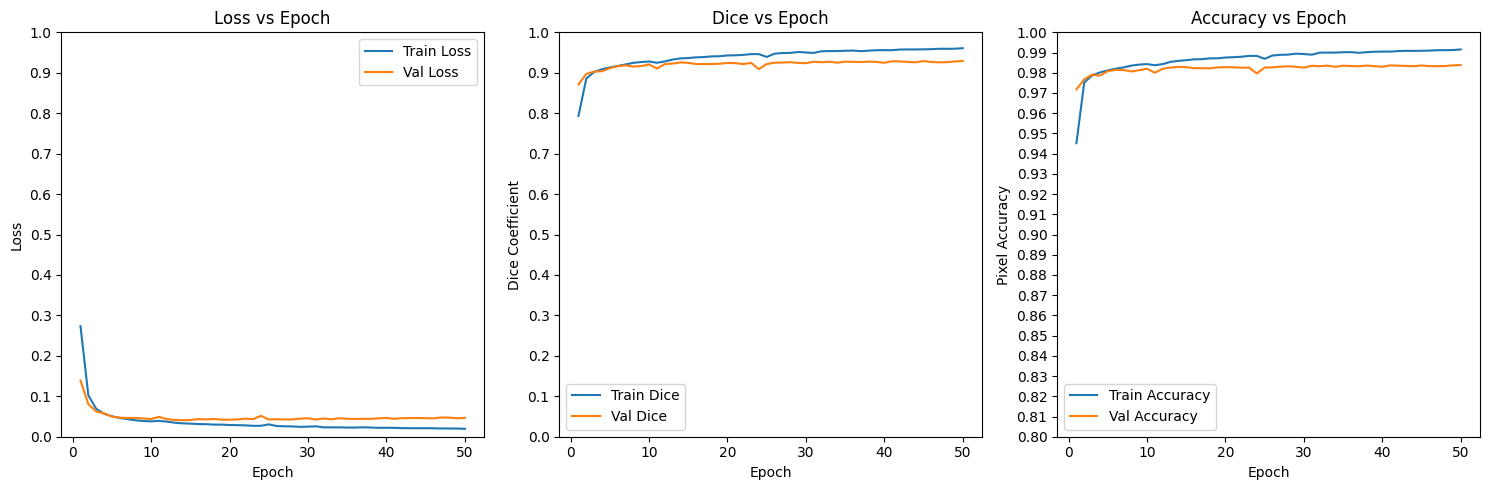

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined:
# num_epochs, train_loss_list, val_loss_list,
# train_dice_mean_list, val_dice_mean_list,
# train_acc_mean_list, val_acc_mean_list

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", linestyle='-')
plt.plot(epochs_range, val_loss_list, label="Val Loss", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Dice vs Epoch
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_mean_list, label="Train Dice", linestyle='-')
plt.plot(epochs_range, val_dice_mean_list, label="Val Dice", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Accuracy vs Epoch (Y-axis adjusted from 0.8 to 1 with 0.01 scale)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_mean_list, label="Train Accuracy", linestyle='-')
plt.plot(epochs_range, val_acc_mean_list, label="Val Accuracy", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.001, 0.01))

plt.tight_layout()
plt.show()


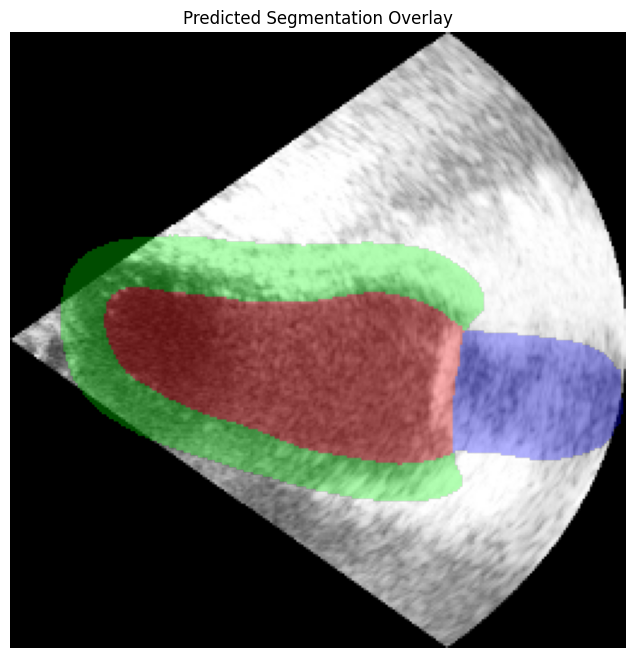

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/Combined_efficientnet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,  # Background + three foreground classes
    activation=None  # No activation because we'll use BCEWithLogitsLoss during training
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/codes/patient0001_2CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# If the image is 3D, select a middle slice
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError("Unexpected image dimensions: expected 2D or 3D image.")

# Optionally normalize the image slice to [0, 1]
img_min = np.min(img_slice)
img_max = np.max(img_slice)
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# ----------------------------
# Resize the image slice to 256x256
img_slice = cv2.resize(img_slice, (256, 256))

# Prepare tensor: add channel and batch dimensions (1, 1, H, W)
img_tensor = torch.tensor(img_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    output = model(img_tensor)  # Output shape: (1, 4, H, W)
    # Convert logits to probabilities
    output = torch.sigmoid(output)
    # For each pixel, choose the class with the maximum probability
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# ----------------------------
# Create an overlay image for the predicted mask
# Define colors for each class in RGBA (background is transparent)
colors = np.array([
    [0,   0,   0,   0],     # Class 0: Background (transparent)
    [255, 0,   0, 128],      # Class 1: Red (semi-transparent)
    [0,   255, 0, 128],      # Class 2: Green (semi-transparent)
    [0,   0, 255, 128]       # Class 3: Blue (semi-transparent)
], dtype=np.uint8)

H, W = pred_mask.shape
overlay = np.zeros((H, W, 4), dtype=np.uint8)
for cls in range(1, 4):  # Skip background (class 0)
    overlay[pred_mask == cls] = colors[cls]

# ----------------------------
# Display and save the overlay image
plt.figure(figsize=(8, 8))
plt.imshow(img_slice, cmap='gray')
plt.imshow(overlay, alpha=0.6)  # Adjust transparency as needed
plt.axis('off')
plt.title('Predicted Segmentation Overlay')
plt.savefig('segmentation_overlay.png', bbox_inches='tight', pad_inches=0)
plt.show()


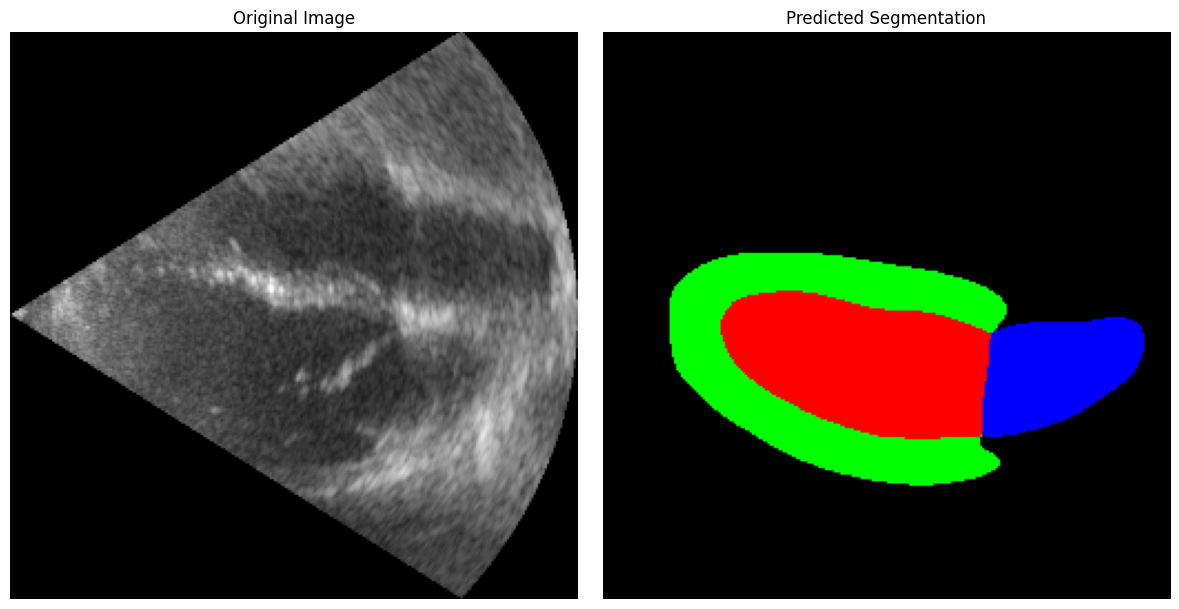

In [17]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/Combined_efficientnet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,  # Background + three foreground classes
    activation=None  # No activation (BCEWithLogitsLoss)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/codes/patient0018_4CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# If the image is 3D, select a middle slice
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError("Unexpected image dimensions: expected 2D or 3D image.")

# Normalize the image slice to [0, 1] for display
img_min, img_max = np.min(img_slice), np.max(img_slice)
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# ----------------------------
# Resize the image slice to 256x256
img_slice = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H, W)
img_tensor = torch.tensor(img_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    output = model(img_tensor)  # (1, 4, 256, 256)
    output = torch.sigmoid(output)  # Convert logits to probabilities
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # (256, 256)

# ----------------------------
# Convert the predicted mask to a color-coded image
# We'll define a color for each class index (0..3).
# Format: BGR + alpha, but we'll only display RGB below.
colors = np.array([
    [0,   0,   0,   0],   # Class 0: background (transparent/black)
    [255, 0,   0,  255],  # Class 1: red
    [0,   255, 0,  255],  # Class 2: green
    [0,   0,  255, 255]   # Class 3: blue
], dtype=np.uint8)

H, W = pred_mask.shape
color_mask = np.zeros((H, W, 4), dtype=np.uint8)

for cls_idx in range(4):
    color_mask[pred_mask == cls_idx] = colors[cls_idx]

# Extract RGB channels (ignore alpha for display)
mask_rgb = color_mask[:, :, :3]

# ----------------------------
# Display the original slice and predicted mask separately
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Original grayscale image
axes[0].imshow(img_slice, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Right: Predicted segmentation (color-coded)
axes[1].imshow(mask_rgb)
axes[1].set_title("Predicted Segmentation")
axes[1].axis('off')

plt.tight_layout()
plt.savefig('segmentation_side_by_side.png', bbox_inches='tight', pad_inches=0)
plt.show()


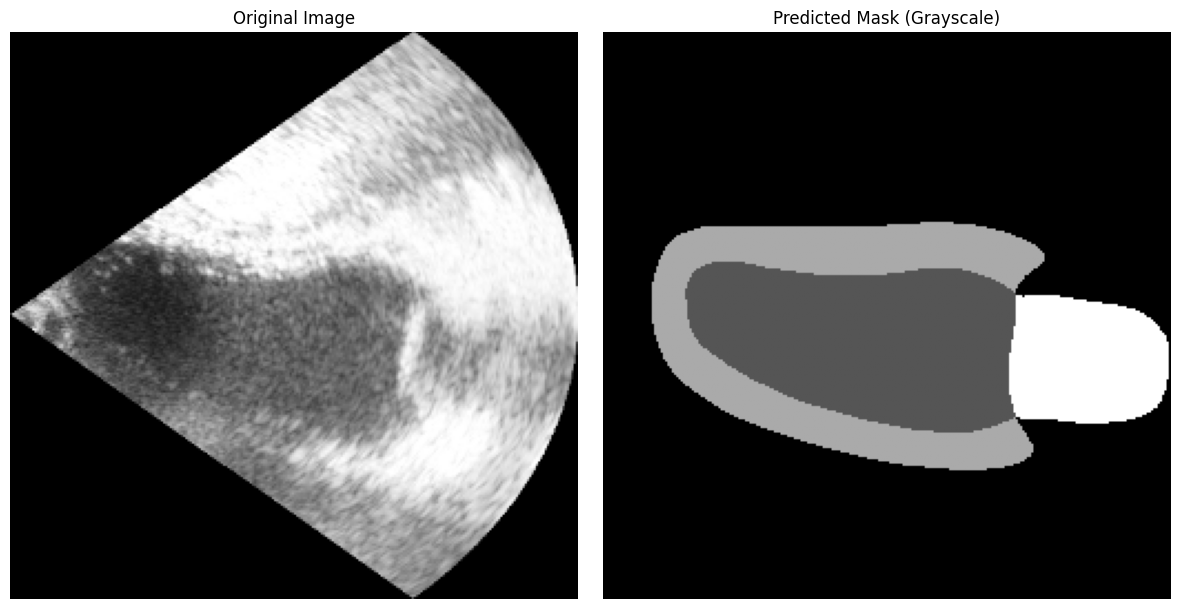

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()


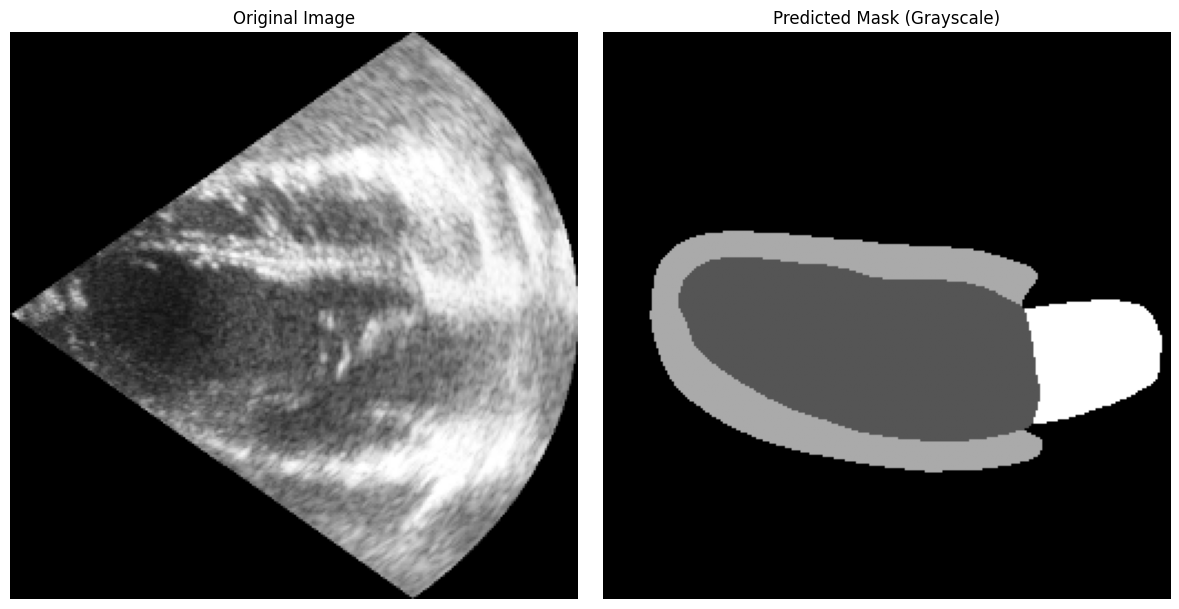

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_4CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [12]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=1):
    
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_multi(y_true, y_pred):
    """
    Compute the mean absolute distance (MAD) between the boundaries of masks,
    channel-by-channel, and return the average.
    """
    distances = []
    channels = y_true.shape[-1]
    for i in range(channels):
        channel_true = y_true[..., i]
        channel_pred = y_pred[..., i]
        # Convert masks to 0-255 and uint8 for contour extraction
        mask_true = (channel_true * 255).astype(np.uint8)
        mask_pred = (channel_pred * 255).astype(np.uint8)
        contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours_true) == 0 or len(contours_pred) == 0:
            distances.append(np.nan)
        else:
            # Combine all contour points for each mask
            points_true = np.vstack(contours_true)[:, 0, :]
            points_pred = np.vstack(contours_pred)[:, 0, :]
            dists = []
            for pt in points_true:
                dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
            distances.append(np.mean(dists))
    return np.nanmean(distances)

def compute_mae(y_true, y_pred):
    """
    Compute Mean Absolute Error between masks (pixel-wise).
    """
    return mean_absolute_error(y_true.flatten(), y_pred.flatten())

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient between ground truth and prediction.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function
# -------------------------------

def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model on the given dataloader and compute various metrics.
    Assumes the model outputs logits and the masks are in the range [0,1].
    """
    dice_scores = []
    jaccard_scores = []
    hausdorff_scores = []
    mae_scores = []
    mad_scores = []
    accuracies = []
    precisions = []
    recalls = []
    correlations = []

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            # If the model returns a tuple, select the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Apply sigmoid and threshold to get binary predictions
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move to CPU and convert to numpy
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # The outputs are of shape (batch, channels, H, W).
            # For our metric functions, we transpose to (batch, H, W, channels).
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Binarize the ground truth mask if necessary
                true_mask_binary = (true_mask > threshold).astype(np.float32)

                dice_scores.append(dice_coefficient(true_mask_binary, pred_mask))
                jaccard_scores.append(jaccard_index(true_mask_binary, pred_mask))
                hausdorff_scores.append(hausdorff_distance_single(true_mask_binary, pred_mask))
                mae_scores.append(compute_mae(true_mask_binary, pred_mask))
                mad_scores.append(mean_absolute_distance_multi(true_mask_binary, pred_mask))

                acc, prec, rec = compute_classification_metrics(true_mask_binary, pred_mask)
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)

                correlations.append(compute_correlation(true_mask_binary, pred_mask))

    print("---- Evaluation Metrics ----")
    print("Average Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores), np.nanstd(dice_scores)))
    print("Average Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores), np.nanstd(jaccard_scores)))
    print("Average Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores), np.nanstd(hausdorff_scores)))
    print("Average Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores), np.std(mae_scores)))
    print("Average Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores), np.std(mad_scores)))
    print("Average Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))
    print("Average Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions), np.std(precisions)))
    print("Average Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls), np.std(recalls)))
    print("Average Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations), np.std(correlations)))

# -------------------------------
# Example usage:
# -------------------------------
# Assuming `model`, `val_loader`, and `device` are defined,
# and that the model weights have been loaded correctly.

# Load your saved model weights onto CPU
model.load_state_dict(torch.load(r'/home/sailesh/Desktop/Rohit/Combined/denseNet.pth'))
model.to(device)  # device here is 'cpu'
model.eval()

# Evaluate on the validation DataLoader
evaluate_model(model, val_loader, device)


---- Evaluation Metrics ----
Average Dice Coefficient    : 0.9804 ± 0.0098
Average Jaccard Index       : 0.9618 ± 0.0185
Average Hausdorff Distance  : 2.9373 ± 0.2170
Average Mean Absolute Error : 0.0098 ± 0.0049
Average Mean Absolute Dist  : 1.1568 ± 0.8256
Average Accuracy            : 0.9902 ± 0.0049
Average Precision           : 0.9805 ± 0.0099
Average Recall              : 0.9804 ± 0.0098
Average Correlation         : 0.9739 ± 0.0131


In [11]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff  # No longer used in soft version
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer

    # Compute the minimum distance from each point in coords_true to any point in coords_pred.
    min_distances_true_to_pred = [np.min(np.linalg.norm(coords_pred - a, axis=1))
                                  for a in coords_true]
    max_true_to_pred = np.max(min_distances_true_to_pred)

    # Compute the minimum distance from each point in coords_pred to any point in coords_true.
    min_distances_pred_to_true = [np.min(np.linalg.norm(coords_true - b, axis=1))
                                  for b in coords_pred]
    max_pred_to_true = np.max(min_distances_pred_to_true)

    # The Hausdorff distance is the maximum of these two distances.
    distance_in_pixels = max(max_true_to_pred, max_pred_to_true)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Assumes:
      - The model outputs logits.
      - The ground truth masks are in the range [0, 1].
      - There are 4 channels: channel 0 is background and channels 1, 2, and 3 correspond to Lobe_1, Lobe_2, and Lobe_3.
    """
    num_segments = 4  # Background + 3 lobes

    # Create a list for each metric per channel
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            # If the model returns a tuple, select the first element
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Iterate over segmentation channels (skip background channel 0)
                for seg in range(1, num_segments):
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Binarize the ground truth channel using the same threshold
                    channel_true_bin = (channel_true > threshold).astype(np.float32)

                    dice_scores[seg].append(dice_coefficient(channel_true_bin, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true_bin, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true_bin, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true_bin.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true_bin, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true_bin, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true_bin, channel_pred))

    # Print averaged metrics (mean ± standard deviation) for each lobe (skipping background)
    for seg in range(1, num_segments):
        print(f"---- Metrics for Lobe_{seg} ----")
        print("Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores[seg]), np.nanstd(dice_scores[seg])))
        print("Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores[seg]), np.nanstd(jaccard_scores[seg])))
        print("Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores[seg]), np.nanstd(hausdorff_scores[seg])))
        print("Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores[seg]), np.std(mae_scores[seg])))
        print("Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores[seg]), np.std(mad_scores[seg])))
        print("Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies[seg]), np.std(accuracies[seg])))
        print("Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions[seg]), np.std(precisions[seg])))
        print("Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls[seg]), np.std(recalls[seg])))
        print("Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations[seg]), np.std(correlations[seg])))
        print("-----------------------------\n")

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------

# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


---- Metrics for Lobe_1 ----
Dice Coefficient    : 0.9608 ± 0.0272
Jaccard Index       : 0.9257 ± 0.0455
Hausdorff Distance  : 2.3634 ± 1.5244
Mean Absolute Error : 0.0068 ± 0.0044
Mean Absolute Dist  : 1.3516 ± 0.7812
Accuracy            : 0.9932 ± 0.0044
Precision           : 0.9584 ± 0.0347
Recall              : 0.9652 ± 0.0416
Correlation         : 0.9575 ± 0.0267
-----------------------------

---- Metrics for Lobe_2 ----
Dice Coefficient    : 0.9254 ± 0.0346
Jaccard Index       : 0.8630 ± 0.0562
Hausdorff Distance  : 3.0552 ± 1.6378
Mean Absolute Error : 0.0149 ± 0.0086
Mean Absolute Dist  : 1.4128 ± 0.7059
Accuracy            : 0.9851 ± 0.0086
Precision           : 0.9288 ± 0.0424
Recall              : 0.9236 ± 0.0431
Correlation         : 0.9175 ± 0.0378
-----------------------------

---- Metrics for Lobe_3 ----
Dice Coefficient    : 0.9427 ± 0.0461
Jaccard Index       : 0.8948 ± 0.0733
Hausdorff Distance  : 2.5291 ± 1.8062
Mean Absolute Error : 0.0050 ± 0.0030
Mean Absolute D

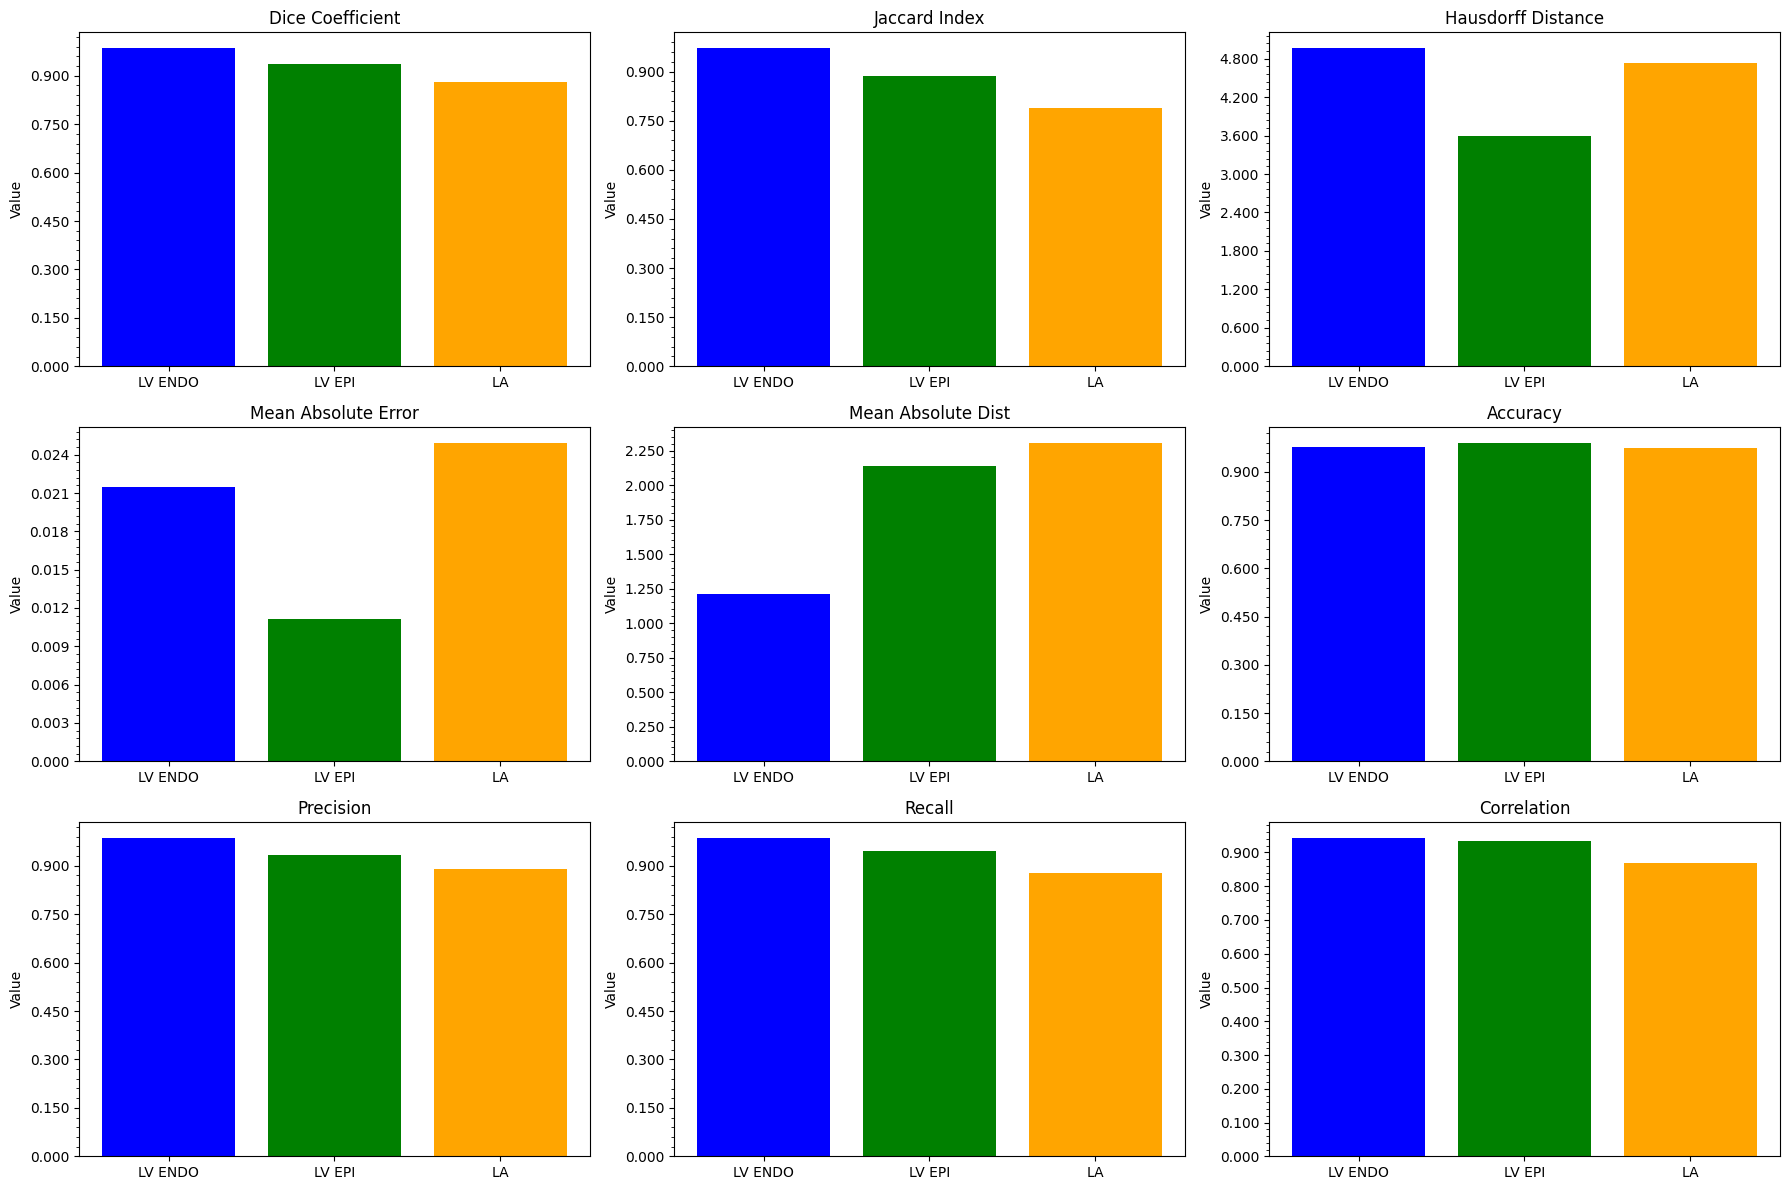

In [18]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Segments are assumed to be: LV ENDO, LV EPI, and LA.
    Then, create bar plots for each metric with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Compute average metrics for each segment
    avg_dice = [np.nanmean(dice_scores[seg]) for seg in range(num_segments)]
    avg_jaccard = [np.nanmean(jaccard_scores[seg]) for seg in range(num_segments)]
    avg_hausdorff = [np.nanmean(hausdorff_scores[seg]) for seg in range(num_segments)]
    avg_mae = [np.mean(mae_scores[seg]) for seg in range(num_segments)]
    avg_mad = [np.mean(mad_scores[seg]) for seg in range(num_segments)]
    avg_accuracy = [np.mean(accuracies[seg]) for seg in range(num_segments)]
    avg_precision = [np.mean(precisions[seg]) for seg in range(num_segments)]
    avg_recall = [np.mean(recalls[seg]) for seg in range(num_segments)]
    avg_corr = [np.mean(correlations[seg]) for seg in range(num_segments)]

    # Define metric names and corresponding average values
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    metrics_values = [avg_dice, avg_jaccard, avg_hausdorff, avg_mae, avg_mad,
                      avg_accuracy, avg_precision, avg_recall, avg_corr]

    # Create a 3x3 grid of bar plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['LV ENDO', 'LV EPI', 'LA']
    for i, ax in enumerate(axs):
        ax.bar(segments, metrics_values[i], color=['blue', 'green', 'orange'])
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

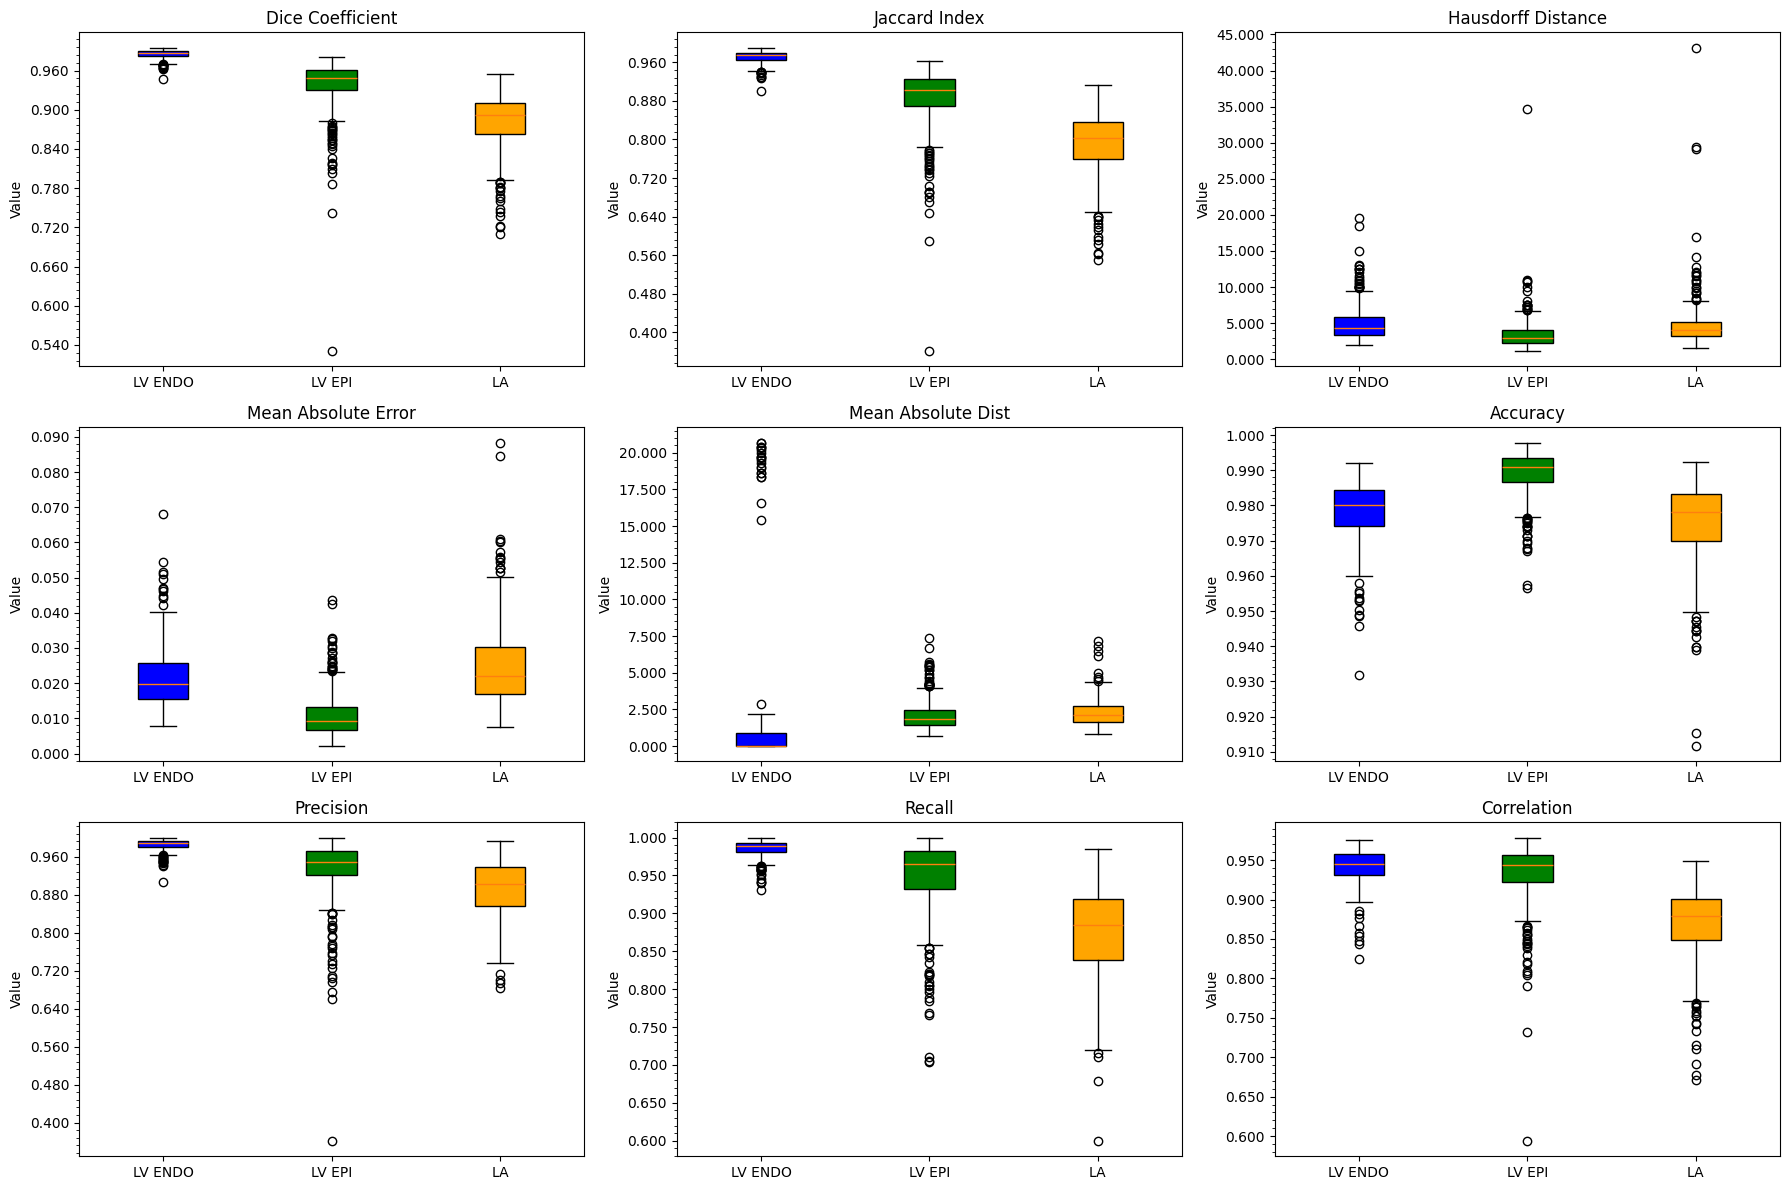

In [19]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Then, create box plots for each metric comparing LV ENDO, LV EPI, and LA with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and corresponding distributions (one per segment)
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    
    # Create a list of lists containing distributions for each metric:
    metrics_distributions = [
        dice_scores,
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    
    # Create a 3x3 grid of box plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['LV ENDO', 'LV EPI', 'LA']
    for i, ax in enumerate(axs):
        # Create a box plot for the metric distribution across segments
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Customize box colors if desired:
        colors = ['blue', 'green', 'orange']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

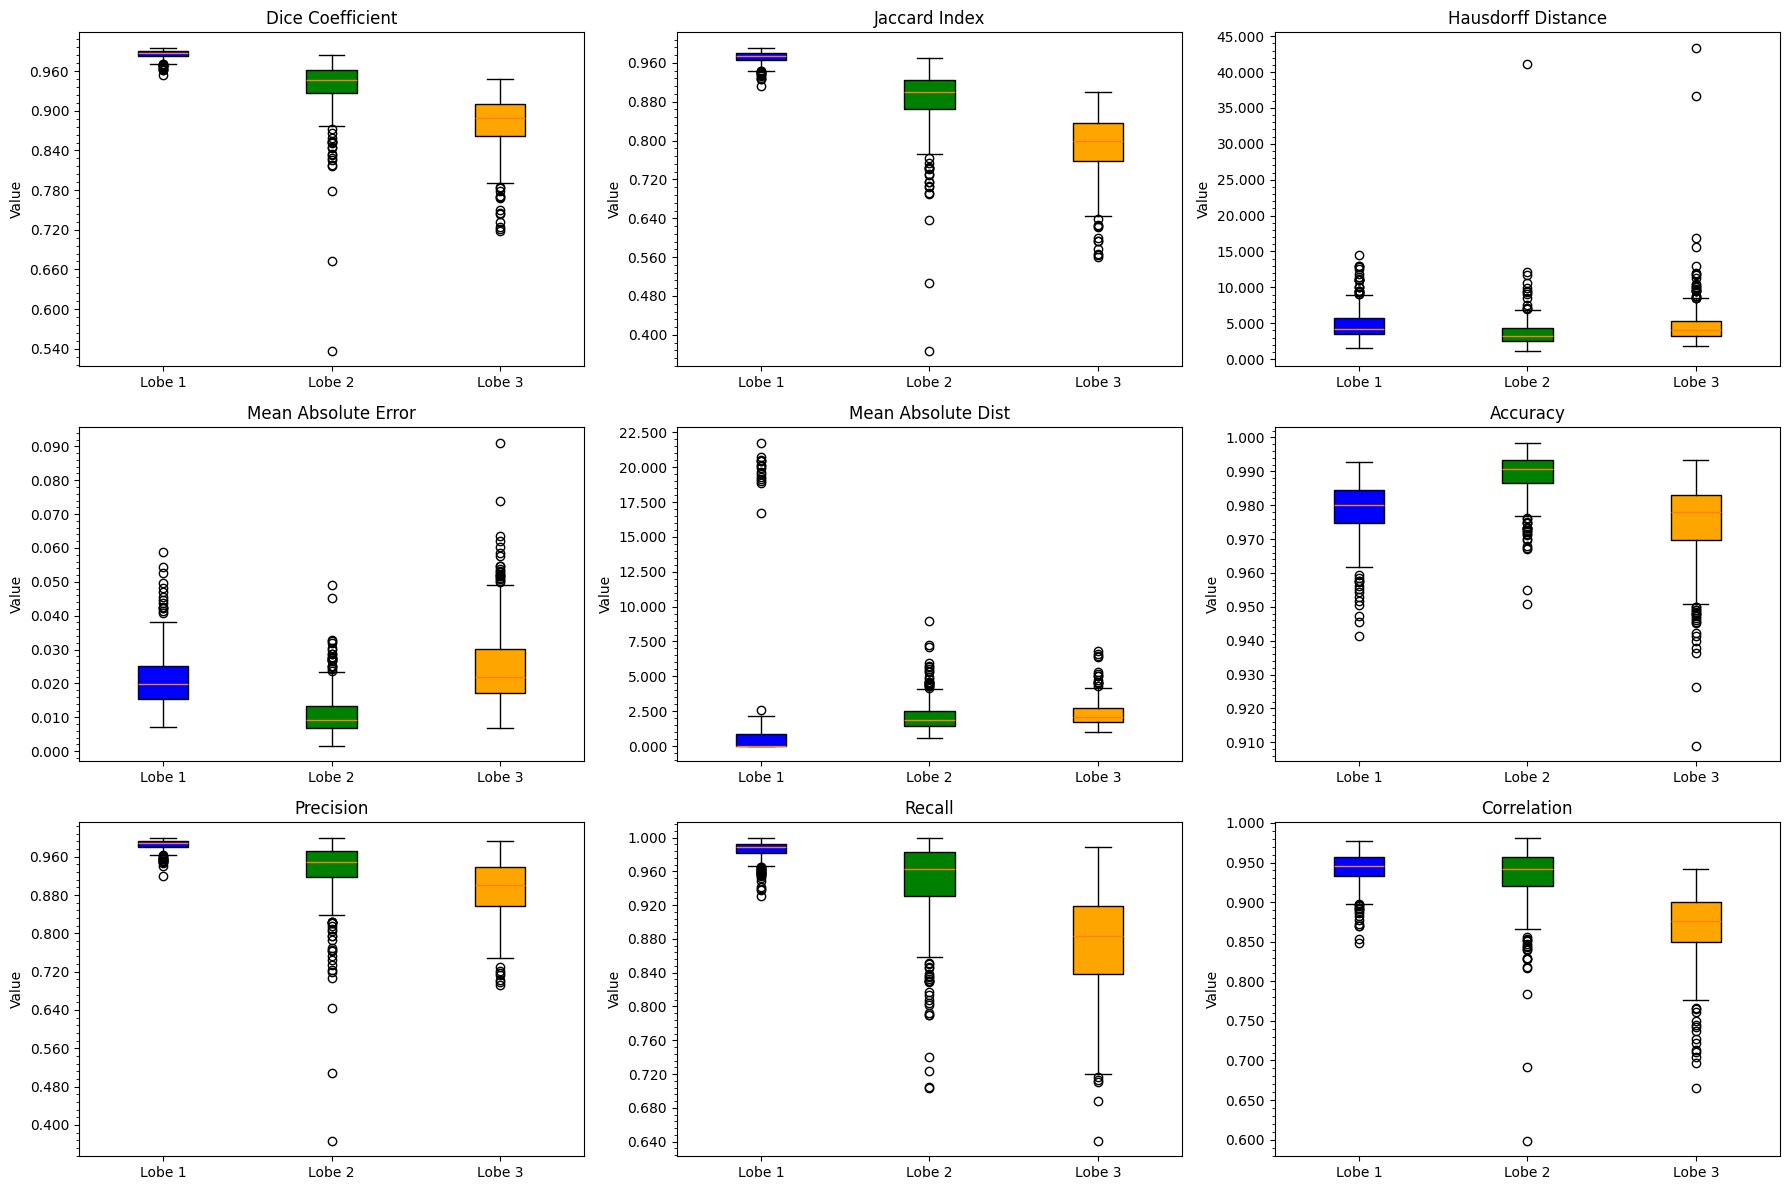

In [20]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Then, create box plots for each metric comparing Lobe_1, Lobe_2, and Lobe_3 with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For Lobe_1, Lobe_2, and Lobe_3

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and corresponding distributions (one per lobe)
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    
    # Create a list of lists containing distributions for each metric:
    metrics_distributions = [
        dice_scores,       # Each element is a list of values for Lobe 1, 2, and 3 respectively
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    
    # Create a 3x3 grid of box plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['Lobe 1', 'Lobe 2', 'Lobe 3']
    for i, ax in enumerate(axs):
        # Create a box plot for the metric distribution across lobes
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Optionally, customize box colors:
        colors = ['blue', 'green', 'orange']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_2086506/1459088328.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(dice_scores, labels=segments, patch_artist=True)


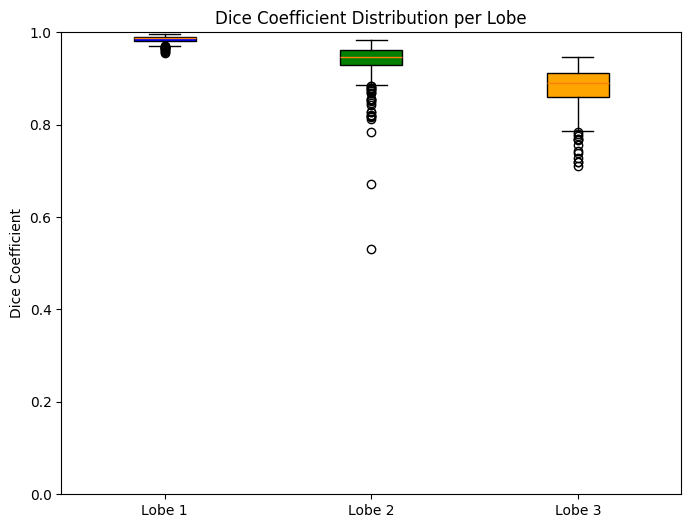

In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Function to evaluate the Dice scores for each lobe
def evaluate_dice(model, dataloader, device, threshold=0.5):
    """
    Evaluate Dice coefficient for each segmentation channel (lobe) and return the per-sample distributions.
    """
    num_segments = 3  # Assuming 3 lobes: Lobe 1, Lobe 2, and Lobe 3
    dice_scores = [[] for _ in range(num_segments)]
    
    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            # Move to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()
            
            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))
            
            # Evaluate Dice for each lobe per sample
            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
    return dice_scores

# Evaluate Dice scores on your validation DataLoader
dice_scores = evaluate_dice(model, val_loader, device)

# Plot the Dice coefficient distribution as a box plot
plt.figure(figsize=(8, 6))
segments = ['Lobe 1', 'Lobe 2', 'Lobe 3']
bp = plt.boxplot(dice_scores, labels=segments, patch_artist=True)
colors = ['blue', 'green', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title("Dice Coefficient Distribution per Lobe")
plt.ylabel("Dice Coefficient")
plt.ylim(0, 1)
plt.show()


/tmp/ipykernel_2086506/2894801135.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2894801135.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2894801135.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2894801135.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

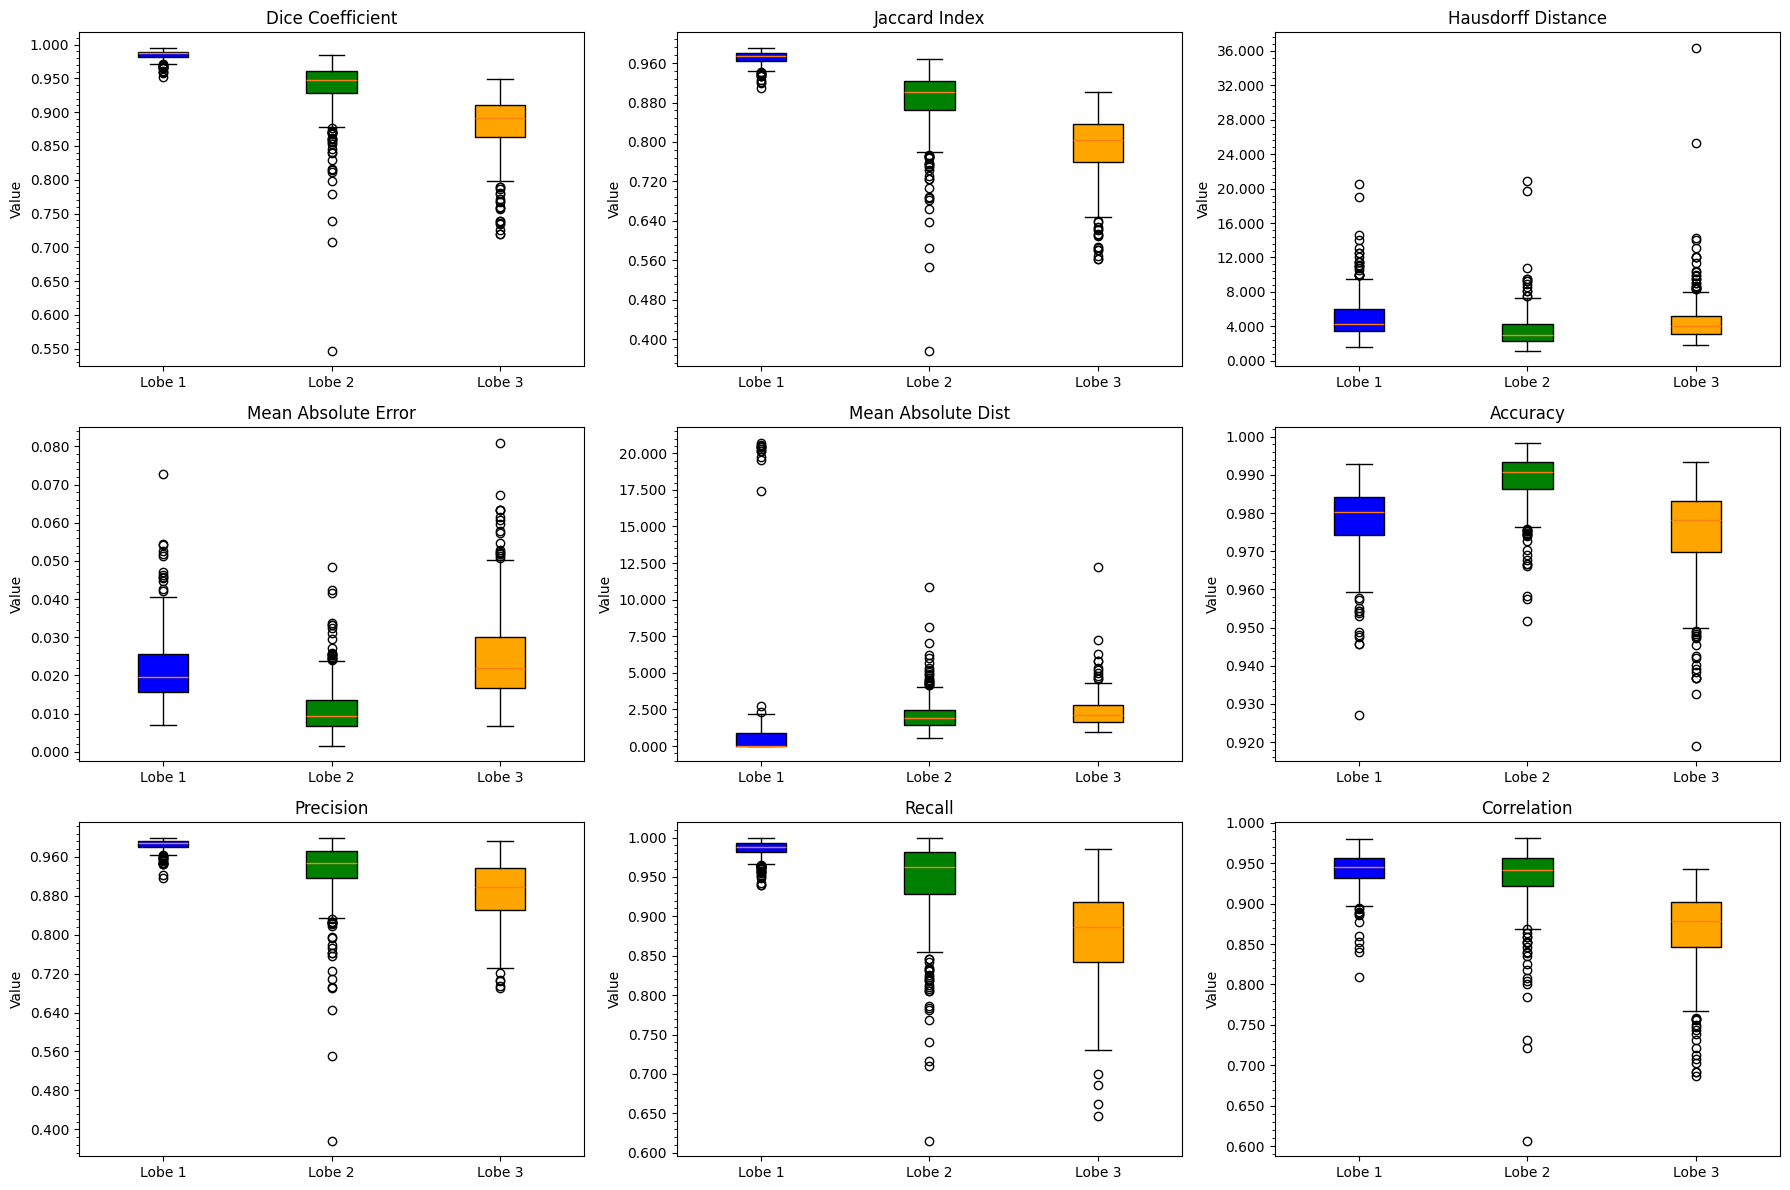

In [22]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask 
    and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]
    dists = [np.min(np.linalg.norm(points_pred - pt, axis=1)) for pt in points_true]
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Every Metric
# -------------------------------

def evaluate_model_metrics(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model on the provided dataloader and compute per-sample metric values
    for each segmentation channel (lobe). Returns a dictionary where each key is a metric name,
    and its value is a list of three lists corresponding to the distributions (over samples)
    for Lobe 1, Lobe 2, and Lobe 3.
    """
    num_segments = 3  # Lobe 1, Lobe 2, Lobe 3
    
    # Prepare lists to collect per-sample metric values for each lobe
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]
    
    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            preds = (torch.sigmoid(outputs) > threshold).float()
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()
            
            # Rearrange shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))
            
            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]
                    
                    # Compute and store each metric for the given channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))
                    
                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)
                    
                    correlations[seg].append(compute_correlation(channel_true, channel_pred))
    
    # Organize the distributions in a dictionary
    metrics_dict = {
        "Dice Coefficient": dice_scores,
        "Jaccard Index": jaccard_scores,
        "Hausdorff Distance": hausdorff_scores,
        "Mean Absolute Error": mae_scores,
        "Mean Absolute Dist": mad_scores,
        "Accuracy": accuracies,
        "Precision": precisions,
        "Recall": recalls,
        "Correlation": correlations,
    }
    return metrics_dict

# -------------------------------
# Plotting All Metrics with Box Plots
# -------------------------------

def plot_metrics_boxplots(metrics_dict):
    """
    Create a grid of box plots (one subplot per metric) showing the distribution
    of each metric (for Lobe 1, Lobe 2, and Lobe 3).
    """
    metrics_names = list(metrics_dict.keys())
    metrics_distributions = [metrics_dict[m] for m in metrics_names]
    
    # Create a 3x3 grid (for 9 metrics)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['Lobe 1', 'Lobe 2', 'Lobe 3']
    colors = ['blue', 'green', 'orange']
    
    for i, ax in enumerate(axs):
        # Create a box plot for each metric distribution across the lobes
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Customize box colors
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Improve y-axis tick precision
        ax.yaxis.set_major_locator(MaxNLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Use These Functions
# -------------------------------
# After training (or loading your best model), call these functions.
# For example, assuming you have: model, val_loader, and device already defined:

metrics_dict = evaluate_model_metrics(model, val_loader, device)
plot_metrics_boxplots(metrics_dict)


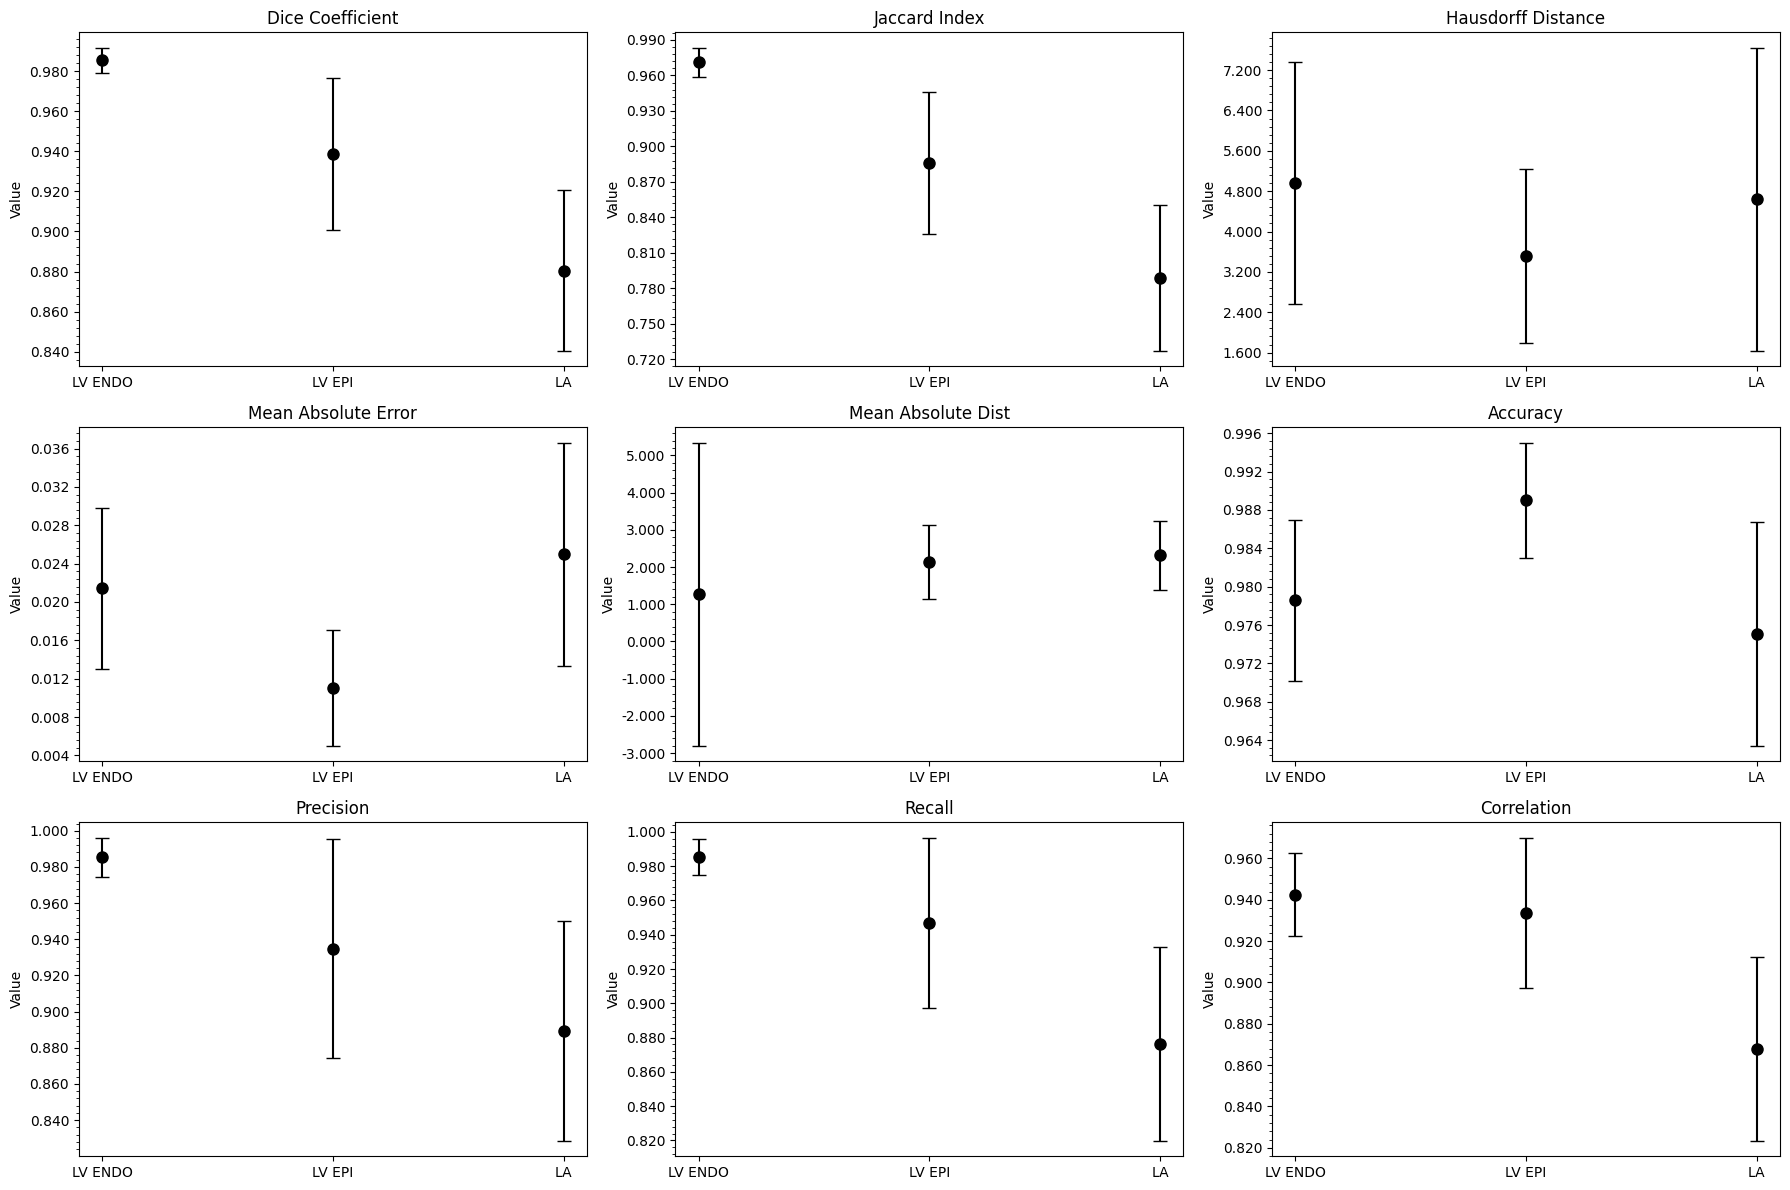

In [23]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment with Error Bar Plot
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Segments are assumed to be: LV ENDO, LV EPI, and LA.
    Then, create a multi-channel error bar plot for each metric (mean ± std) with precise y-axis scaling.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Initialize lists to collect per-sample metric values for each channel.
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions using thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the channel corresponding to each segment.
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute and store metrics for this channel.
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and organize the distributions for each metric.
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    metrics_distributions = [
        dice_scores,
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    channels = ['LV ENDO', 'LV EPI', 'LA']

    # Create a 3x3 grid of error bar plots (one subplot per metric).
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        # Compute mean and standard deviation for each channel of the current metric.
        means = [np.nanmean(metrics_distributions[i][ch]) for ch in range(num_segments)]
        stds = [np.nanstd(metrics_distributions[i][ch]) for ch in range(num_segments)]
        x = np.arange(len(channels))
        # Plot mean values with error bars representing the standard deviation.
        ax.errorbar(x, means, yerr=stds, fmt='o', capsize=5, color='black', markersize=8)
        ax.set_title(metrics_names[i])
        ax.set_xticks(x)
        ax.set_xticklabels(channels)
        ax.set_ylabel("Value")
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks.
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors.
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals.
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


In [10]:
import torch
import torch.nn.functional as F

def lrp_0(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-0 rule:
      R_j <- Σ_i ( z_ji / (Σ_j z_ji + ε) ) * R_i
    where z_ji = w_ji * a_j.
    """
    # Forward pass
    z = layer(input_activation)
    
    # Compute the "distribution" factor
    s = relevance / (z + epsilon)
    
    # Backprop relevance
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_epsilon(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-ε rule (epsilon rule):
      R_j <- Σ_i ( z_ji + ε·sign(z_ji) ) / (Σ_j z_ji + ε·sign(Σ_j z_ji)) * R_i
    We implement a simplified version:
      1) Forward pass to get z
      2) Add small epsilon * sign(z) to stabilize
      3) Distribute relevance
      4) Gradient w.r.t. original z
    """
    z = layer(input_activation)
    
    # Add a sign-based stabilizer
    sign_z = torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))
    z_eps = z + epsilon * sign_z
    
    # Distribute relevance
    s = relevance / z_eps
    # Use gradient w.r.t. z (not z_eps), so we pass `z` below:
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_z_plus(layer, input_activation, relevance, epsilon=1e-6):
    """
    z+ (ε) rule:
      Only the positive contributions are considered in z.
      R_j <- Σ_i ( z_ji^+ / (Σ_j z_ji^+ + ε) ) * R_i
    """
    # Forward pass
    z = layer(input_activation)
    
    # Keep only positive contributions
    z_plus = torch.clamp(z, min=0)
    
    # Distribute relevance based on z+ only
    s = relevance / (z_plus + epsilon)
    
    # We take gradient wrt z_plus to zero-out negative paths
    c = torch.autograd.grad(z_plus, input_activation, s, retain_graph=True)[0]
    
    # Multiply by positive part of input as well (common variant)
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_gamma(layer, input_activation, relevance, gamma=0.5, epsilon=1e-6):
    """
    LRP-γ rule:
      Scales positive weights by (1+γ) to boost positive contributions.
    """
    # Temporarily modify layer weights for the forward pass
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = W_original.clone()
        # Scale only positive weights by (1 + gamma)
        W_modified[W_modified > 0] = W_modified[W_modified > 0] * (1.0 + gamma)
        layer.weight.data = W_modified
    
    # Forward pass with scaled weights
    z_mod = layer(input_activation)
    z_mod_plus = torch.clamp(z_mod, min=0)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_mod_plus + epsilon)
    c = torch.autograd.grad(z_mod_plus, input_activation, s, retain_graph=True)[0]
    
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_alpha_beta(layer, input_activation, relevance, alpha=0.9, beta=0.1, epsilon=1e-6):
    z = layer(input_activation)
    
    z_pos = torch.clamp(z, min=0)
    z_neg = torch.clamp(z, max=0)

    # Scale relevance over positive and negative parts separately
    s_pos = relevance / (z_pos + epsilon)
    s_neg = relevance / (z_neg - epsilon)  # negative + ε → subtract for stability

    grad_pos = torch.autograd.grad(z, input_activation, s_pos, retain_graph=True, allow_unused=True)[0]
    grad_neg = torch.autograd.grad(z, input_activation, s_neg, retain_graph=True, allow_unused=True)[0]

    grad_pos = grad_pos if grad_pos is not None else torch.zeros_like(input_activation)
    grad_neg = grad_neg if grad_neg is not None else torch.zeros_like(input_activation)

    Rp = torch.clamp(input_activation, min=0) * torch.clamp(grad_pos, min=0)
    Rn = torch.clamp(input_activation, max=0) * torch.clamp(grad_neg, max=0)

    return alpha * Rp - beta * Rn



def lrp_flat(layer, input_activation, relevance, seg_mask=None):
    """
    Flat rule + optional masking.
    """
    # 1. Forward pass (ignored, just for shape consistency).
    z = layer(input_activation)
    
    # 2. Compute total relevance (sum over output).
    B, outC, outH, outW = z.shape
    B, inC, H, W = input_activation.shape
    total_relevance = relevance.view(B, -1).sum(dim=1, keepdim=True)  # [B,1]
    
    # 3. Distribute uniformly across all input pixels.
    num_input_elements = inC * H * W
    flat_relevance = total_relevance / float(num_input_elements)
    flat_relevance = flat_relevance.view(B, 1, 1, 1).expand(B, inC, H, W)

    # 4. Optional: multiply by segmentation mask to blank out background
    if seg_mask is not None:
        # seg_mask should have shape [B, 1, H, W] or [B, inC, H, W].
        # If needed, broadcast seg_mask to match [B, inC, H, W].
        if seg_mask.shape[1] == 1 and inC > 1:
            seg_mask = seg_mask.expand(-1, inC, -1, -1)
        flat_relevance = flat_relevance * seg_mask
    
    return flat_relevance



def lrp_w_squared(layer, input_activation, relevance, epsilon=1e-6):
    """
    w² rule:
      Relevance is distributed proportionally to w².
    """
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = (W_original**2).clone()
        layer.weight.data = W_modified
    
    z_w2 = layer(input_activation)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_w2 + epsilon)
    c = torch.autograd.grad(z_w2, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


def lrp_zB(layer, input_activation, relevance, l=0.0, h=1.0, epsilon=1e-6):
    """
    z^B rule (bounded rule).
    """
    z = layer(input_activation)
    
    W = layer.weight
    W_plus = torch.clamp(W, min=0)
    W_minus = torch.clamp(W, max=0)
    
    x_plus = torch.clamp(input_activation, min=0)
    x_minus = torch.clamp(input_activation, max=0)
    
    # zB = z - l·(x^+ * w^+) - h·(x^- * w^-)
    z_b = z
    z_b = z_b - l * F.conv2d(x_plus, W_plus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    z_b = z_b - h * F.conv2d(x_minus, W_minus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    
    s = relevance / (z_b + epsilon)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


In [11]:
# Suppose this is code3.py

lrp_0, lrp_epsilon, lrp_z_plus, lrp_gamma,
lrp_alpha_beta, lrp_flat, lrp_w_squared, lrp_zB

lrp_functions = {
    "LRP-0": lrp_0,
    "epsilon": lrp_epsilon,     # <-- Added here
    "z-plus": lrp_z_plus,
    "gamma": lrp_gamma,
    "alpha-beta": lrp_alpha_beta,
    "flat": lrp_flat,
    "w-squared": lrp_w_squared,
    "zB": lrp_zB
}


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_seg_mask_on_image(image_np, mask_np, alpha=0.5, mask_color=(1, 0, 0)):
    """
    Overlays a binary mask on top of the original image.
      image_np: [H, W, 3], float in [0,1]
      mask_np:  [H, W], float (0 or 1) or something that can be thresholded
      alpha:    blending factor
      mask_color: (R, G, B) in [0,1]
    """
    # Ensure mask is binary or in [0,1]
    mask_bin = (mask_np > 0.5).astype(np.float32)
    
    # Convert mask to 3D color
    mask_3d = np.stack([mask_bin * c for c in mask_color], axis=-1)  # [H, W, 3]
    
    # Blend
    out = (1 - alpha) * image_np + alpha * mask_3d
    return np.clip(out, 0, 1)


def overlay_heatmap_on_image(image_np, heatmap_np, alpha=0.5, cmap='jet'):
    """
    Overlays a continuous heatmap (0..1) on top of the original image.
      image_np:   [H, W, 3], float in [0,1]
      heatmap_np: [H, W], float in [0,1]
      alpha:      blending factor
      cmap:       a matplotlib colormap name
    """
    cm = plt.get_cmap(cmap)
    colored_hm = cm(heatmap_np)[:, :, :3]  # RGBA -> take only RGB
    
    # Blend
    out = (1 - alpha) * image_np + alpha * colored_hm
    return np.clip(out, 0, 1)


In [13]:
def lrp_class_specific(relevance, class_idx):
    """
    Extract the relevance for a specific class.
    Assumes relevance shape is (B, channels, H, W) and returns (B, 1, H, W).
    """
    class_relevance = relevance[:, class_idx, :, :]
    return class_relevance.unsqueeze(1)



def apply_segmentation_mask(relevance, segmentation_output, threshold=0.5):
    """
    Apply a binary mask to the relevance.
    segmentation_output is assumed to be a probability map.
    """
    mask = segmentation_output > threshold
    return relevance * mask

/home/sailesh/miniconda3/envs/rohit_mini/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Segmentation output stats: min = 5.700348637560637e-09 max = 0.9999995231628418 mean = 0.2501225471496582


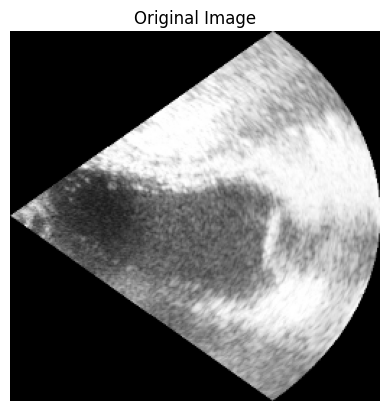

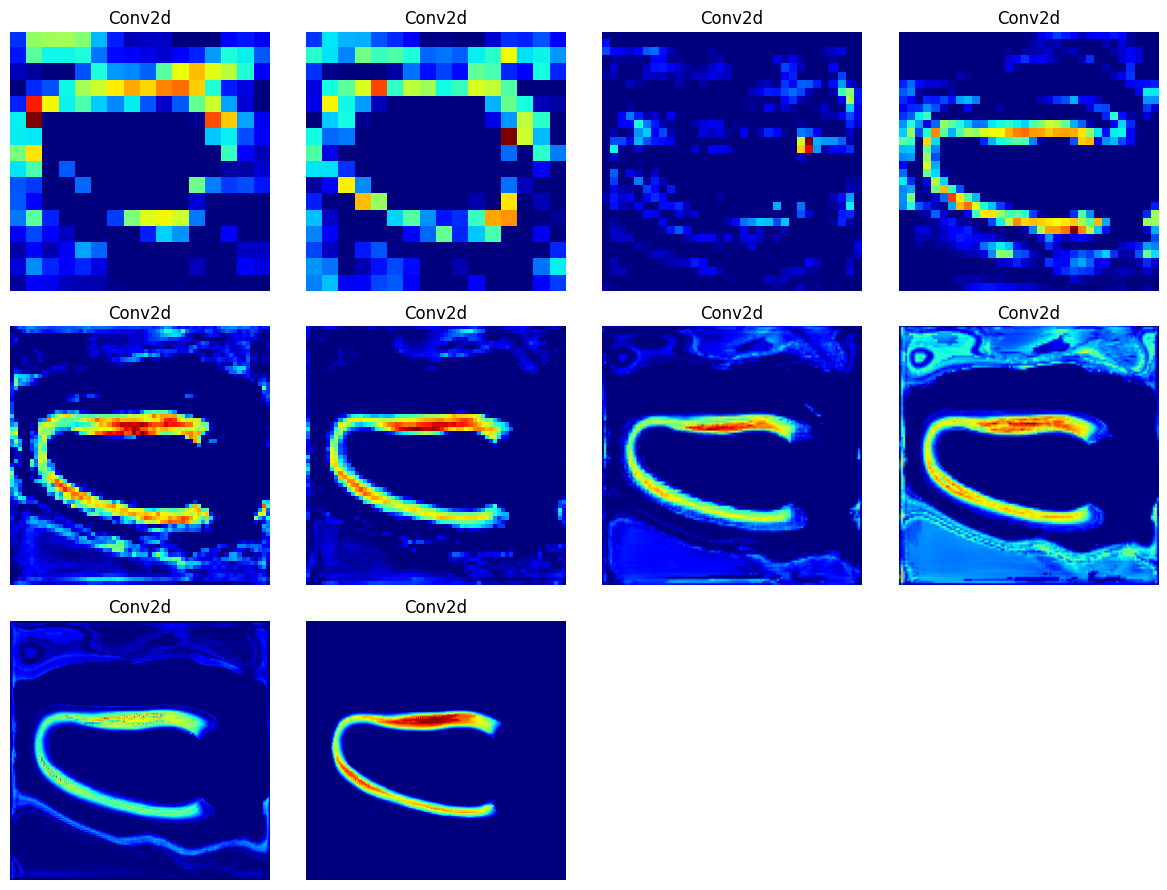

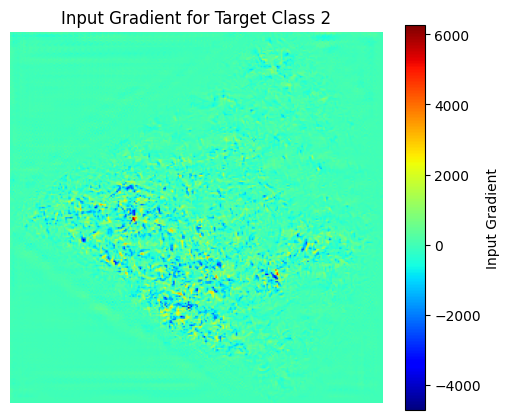

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Hook Functions to Capture Activations and Gradients
# ----------------------------
decoder_activations = {}
decoder_gradients = {}

def forward_hook(module, input, output):
    decoder_activations[module] = output.detach()

def backward_hook(module, grad_input, grad_output):
    # Use the first element of grad_output.
    decoder_gradients[module] = grad_output[0].detach()

def register_decoder_hooks(decoder):
    # Register hooks on all Conv2d layers within the decoder.
    for name, module in decoder.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder.
    # Note: Here, classes=4 where channel 0 is background and channels 1-3 are targets.
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,
        activation=None  # No activation; loss function applies sigmoid if needed.
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Register hooks only for layers within the decoder.
    register_decoder_hooks(model.decoder)
    
    # Load image (shape: [1, 1, H, W]) and set requires_grad.
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Forward Pass ----
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 4, H, W]
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # (Optional) Visualize the original image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)
    orig_img_np = np.clip(orig_img_np, 0, 1)
    plt.figure()
    plt.imshow(orig_img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    # 2. Compute Backward Pass to Populate Gradients in Decoder Layers
    # Choose a target class (e.g., channel 1, a foreground class) for which to compute relevance.
    target_class = 2
    loss = output[0, target_class].sum()
    model.zero_grad()
    loss.backward(retain_graph=True)
    
    # 3. Compute Relevance Maps for Each Conv2d Layer in the Decoder
    # Use a simple rule: relevance = activation * gradient.
    # Then average over channels, clamp negatives to zero, and normalize.
    decoder_relevance = {}
    for module, activation in decoder_activations.items():
        if module not in decoder_gradients:
            continue
        grad = decoder_gradients[module]
        relevance = activation * grad  # Elementwise product.
        # Average over the channel dimension (assumed to be dim=1).
        relevance_map = relevance.mean(dim=1, keepdim=True)
        # Remove negative values.
        relevance_map = torch.clamp(relevance_map, min=0)
        # Normalize the relevance map to [0, 1] for visualization.
        r_min = relevance_map.min()
        r_max = relevance_map.max()
        if r_max > r_min:
            relevance_map = (relevance_map - r_min) / (r_max - r_min)
        else:
            relevance_map = torch.zeros_like(relevance_map)
        # Squeeze batch and channel dimensions to get a 2D array.
        r_np = relevance_map.cpu().numpy().squeeze()
        if r_np.ndim != 2:
            continue
        decoder_relevance[module] = r_np
    
    # 4. Visualize All Decoder Relevance Heatmaps
    num_maps = len(decoder_relevance)
    if num_maps == 0:
        print("No decoder relevance maps found.")
        return
    grid_cols = int(np.ceil(np.sqrt(num_maps)))
    grid_rows = int(np.ceil(num_maps / grid_cols))
    
    plt.figure(figsize=(grid_cols * 3, grid_rows * 3))
    for i, (module, r_map) in enumerate(decoder_relevance.items()):
        plt.subplot(grid_rows, grid_cols, i+1)
        plt.imshow(r_map, cmap='jet')
        plt.title(module.__class__.__name__)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # (Optional) Visualize the input gradient.
    grad_input = image.grad.data[0, 0].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad_input, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Target Class {target_class}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


Segmentation output stats: min = 5.700348637560637e-09 max = 0.9999995231628418 mean = 0.2501225471496582


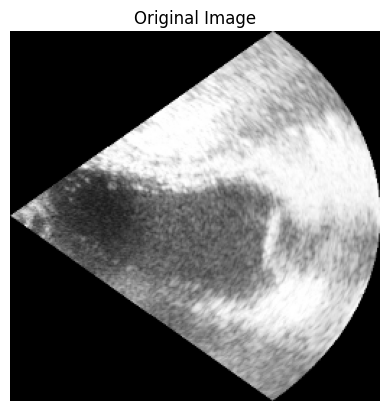

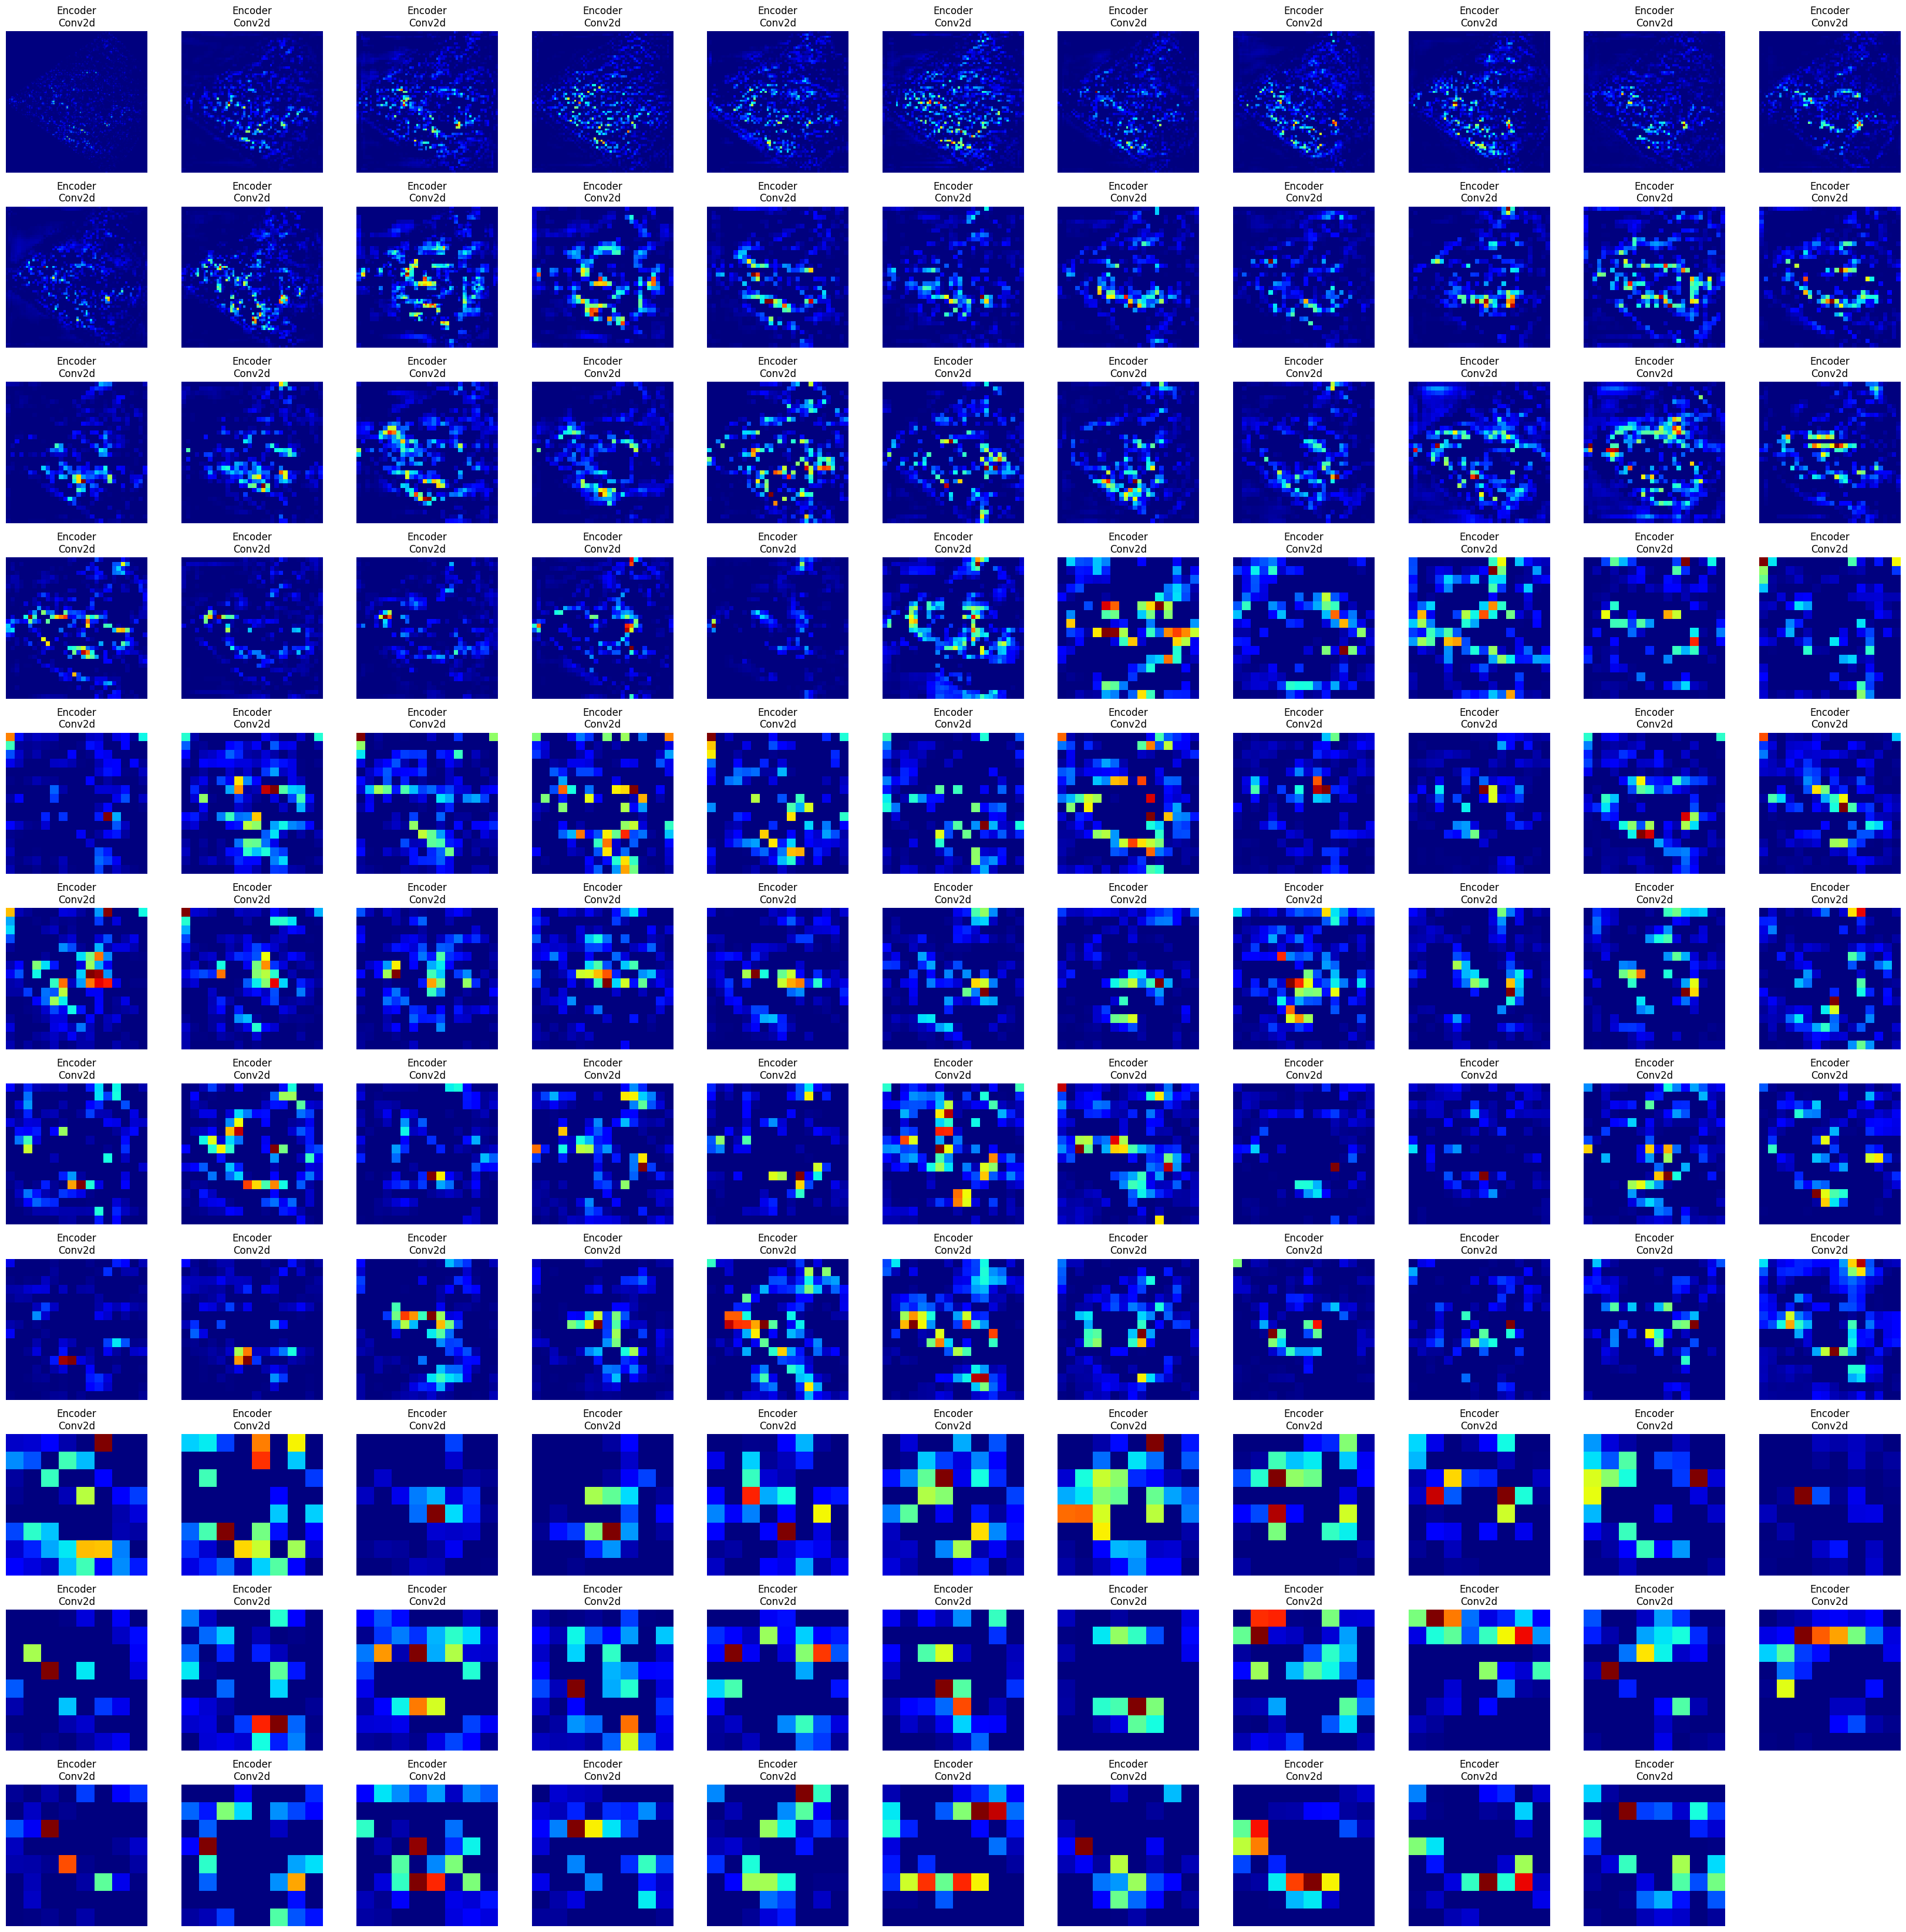

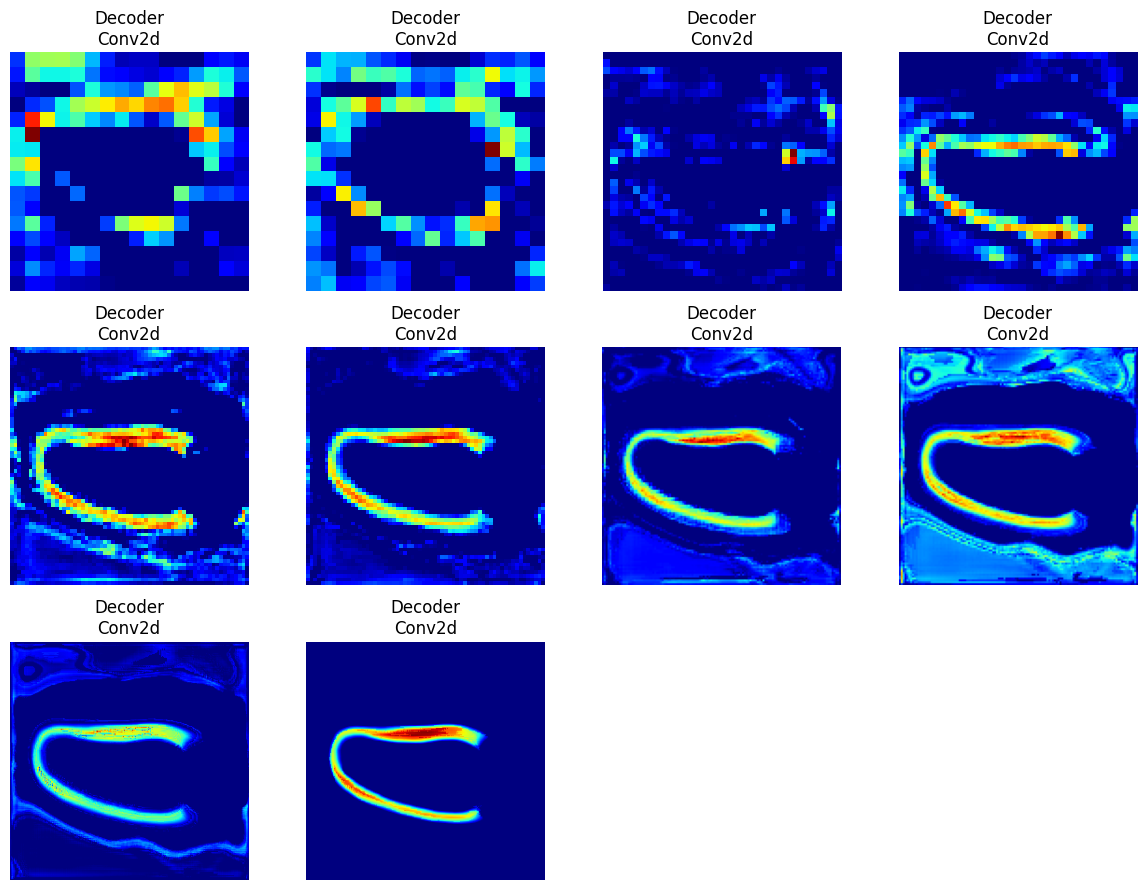

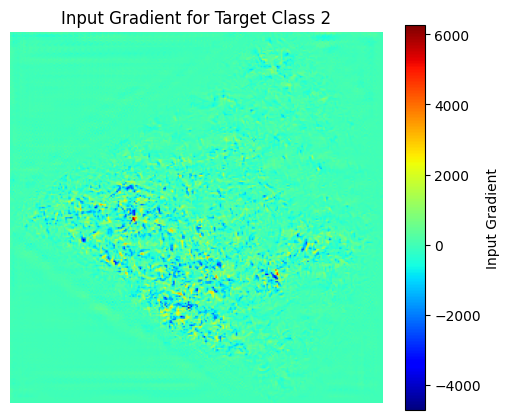

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel and batch dimensions: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Hook Functions and Registration for Encoder and Decoder
# ----------------------------
encoder_activations = {}
encoder_gradients = {}
decoder_activations = {}
decoder_gradients = {}

def forward_hook_encoder(module, input, output):
    encoder_activations[module] = output.detach()

def backward_hook_encoder(module, grad_input, grad_output):
    encoder_gradients[module] = grad_output[0].detach()

def forward_hook_decoder(module, input, output):
    decoder_activations[module] = output.detach()

def backward_hook_decoder(module, grad_input, grad_output):
    decoder_gradients[module] = grad_output[0].detach()

def register_encoder_hooks(encoder):
    for name, module in encoder.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(forward_hook_encoder)
            module.register_backward_hook(backward_hook_encoder)

def register_decoder_hooks(decoder):
    for name, module in decoder.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(forward_hook_decoder)
            module.register_backward_hook(backward_hook_decoder)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder.
    # Here, classes=4 where channel 0 is background and channels 1-3 are target classes.
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,
        activation=None
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Register hooks on both the encoder and the decoder parts.
    register_encoder_hooks(model.encoder)
    register_decoder_hooks(model.decoder)
    
    # Load image and set requires_grad.
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Forward Pass ----
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # [1, 4, H, W]
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # (Optional) Visualize the original image.
    orig_img_np = image[0, 0].detach().cpu().numpy()
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)
    orig_img_np = np.clip(orig_img_np, 0, 1)
    plt.figure()
    plt.imshow(orig_img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    
    # 2. Backward Pass: Compute loss from a target channel (e.g., channel 1 for foreground)
    target_class = 2
    loss = output[0, target_class].sum()
    model.zero_grad()
    loss.backward(retain_graph=True)
    
    # 3. Compute Relevance Maps for Encoder Conv2d Layers
    encoder_relevance = {}
    for module, activation in encoder_activations.items():
        if module not in encoder_gradients:
            continue
        grad = encoder_gradients[module]
        rel = activation * grad
        # Average over channel dimension.
        rel_map = rel.mean(dim=1, keepdim=True)
        # Remove negative values.
        rel_map = torch.clamp(rel_map, min=0)
        # Normalize.
        r_min = rel_map.min()
        r_max = rel_map.max()
        if r_max > r_min:
            rel_map = (rel_map - r_min) / (r_max - r_min)
        else:
            rel_map = torch.zeros_like(rel_map)
        r_np = rel_map.cpu().numpy().squeeze()
        if r_np.ndim != 2:
            continue
        encoder_relevance[module] = r_np
    
    # 4. Compute Relevance Maps for Decoder Conv2d Layers
    decoder_relevance = {}
    for module, activation in decoder_activations.items():
        if module not in decoder_gradients:
            continue
        grad = decoder_gradients[module]
        rel = activation * grad
        rel_map = rel.mean(dim=1, keepdim=True)
        rel_map = torch.clamp(rel_map, min=0)
        r_min = rel_map.min()
        r_max = rel_map.max()
        if r_max > r_min:
            rel_map = (rel_map - r_min) / (r_max - r_min)
        else:
            rel_map = torch.zeros_like(rel_map)
        r_np = rel_map.cpu().numpy().squeeze()
        if r_np.ndim != 2:
            continue
        decoder_relevance[module] = r_np
    
    # 5. Visualization of Encoder Relevance Maps
    num_enc = len(encoder_relevance)
    if num_enc == 0:
        print("No encoder relevance maps found.")
    else:
        grid_cols = int(np.ceil(np.sqrt(num_enc)))
        grid_rows = int(np.ceil(num_enc / grid_cols))
        plt.figure(figsize=(grid_cols * 3, grid_rows * 3))
        for i, (module, r_map) in enumerate(encoder_relevance.items()):
            plt.subplot(grid_rows, grid_cols, i+1)
            plt.imshow(r_map, cmap='jet')
            plt.title(f"Encoder\n{module.__class__.__name__}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    # 6. Visualization of Decoder Relevance Maps
    num_dec = len(decoder_relevance)
    if num_dec == 0:
        print("No decoder relevance maps found.")
    else:
        grid_cols = int(np.ceil(np.sqrt(num_dec)))
        grid_rows = int(np.ceil(num_dec / grid_cols))
        plt.figure(figsize=(grid_cols * 3, grid_rows * 3))
        for i, (module, r_map) in enumerate(decoder_relevance.items()):
            plt.subplot(grid_rows, grid_cols, i+1)
            plt.imshow(r_map, cmap='jet')
            plt.title(f"Decoder\n{module.__class__.__name__}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    # (Optional) Visualize Input Gradient
    grad_input = image.grad.data[0, 0].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad_input, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Target Class {target_class}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


Missing keys: []
Unexpected keys: []
Seg stats: 5.700348637560637e-09 0.9999995231628418 0.2501225471496582

=== LRP Rule: LRP-0 ===
  raw relevance: -11483.5947265625 14586.54296875 -2.38462233543396


/tmp/ipykernel_2444551/457211371.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_map = cm.get_cmap(cmap)



=== LRP Rule: epsilon ===
  raw relevance: -11483.5947265625 14586.544921875 -2.384631395339966


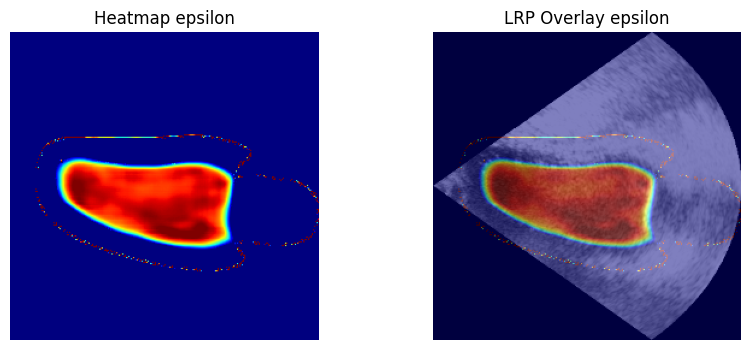


=== LRP Rule: z-plus ===
  raw relevance: 0.0 18663.27734375 1.4118497371673584


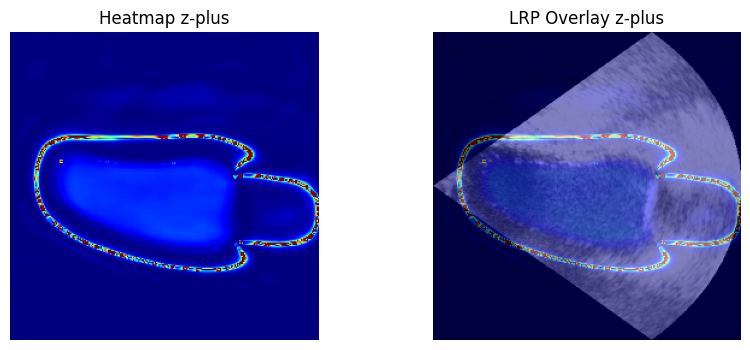


=== LRP Rule: gamma ===
  raw relevance: 0.0 2049.52392578125 0.5268621444702148


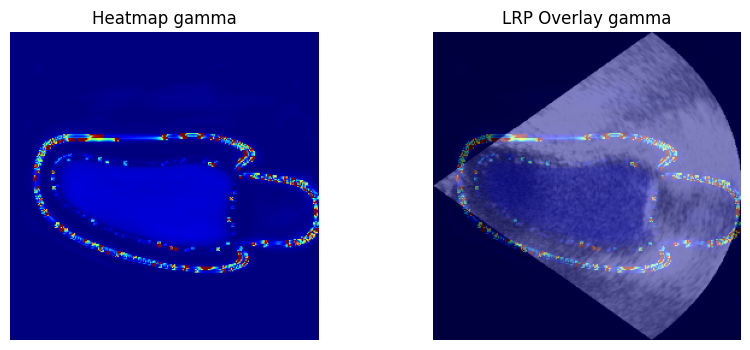


=== LRP Rule: alpha-beta ===
  raw relevance: 0.0 50552732.0 20364628.0


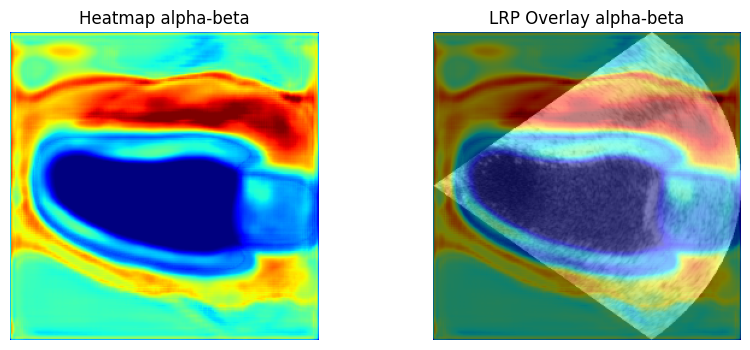


=== LRP Rule: flat ===
  raw relevance: -0.5944735407829285 -0.5944735407829285 -0.5944735407829285


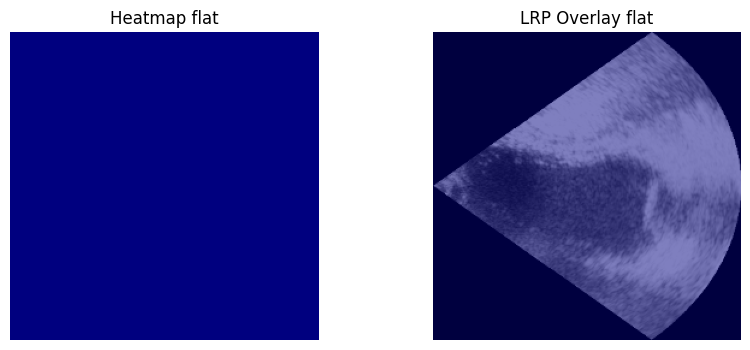


=== LRP Rule: w-squared ===
  raw relevance: -5.816316604614258 11.064032554626465 5.998711585998535


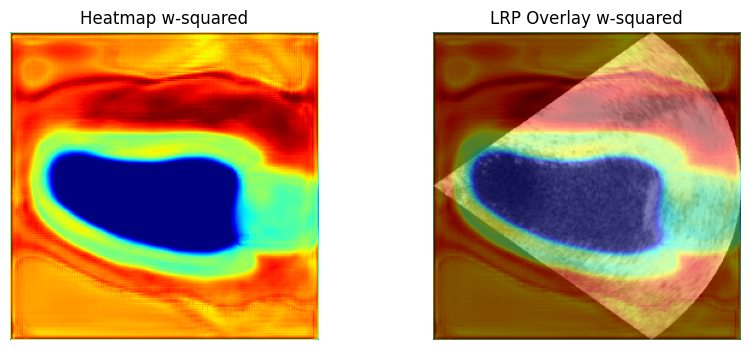


=== LRP Rule: zB ===
  raw relevance: -11483.5947265625 14586.54296875 -2.38462233543396


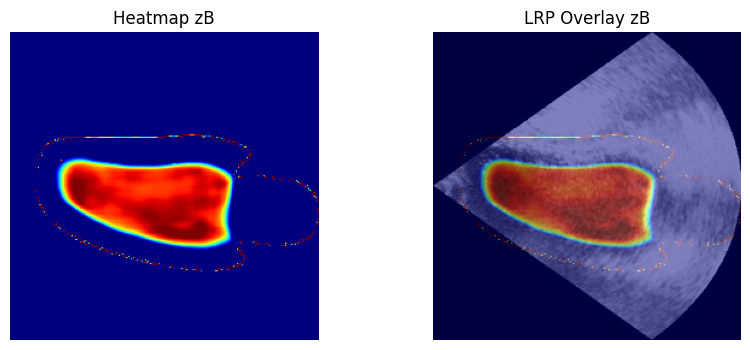

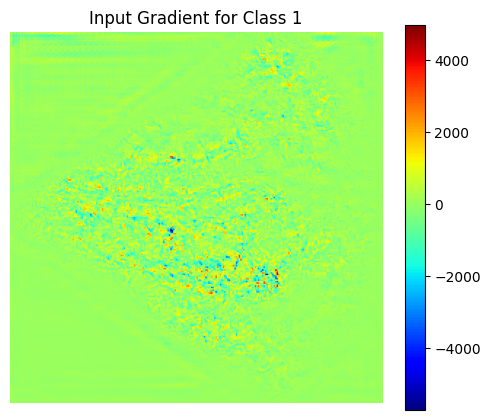

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import segmentation_models_pytorch as smp
import matplotlib.cm as cm

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If 3D, take middle slice (or squeeze if singleton)
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_idx = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_idx]
    
    # Normalize to [0, 1]
    mn, mx = img_data.min(), img_data.max()
    img = (img_data - mn) / (mx - mn) if mx > mn else img_data - mn
    
    # Resize (cv2 expects (width, height))
    img = cv2.resize(img.astype(np.float32), target_size)
    
    # Add channel and batch dims: [1,1,H,W]
    img = img[None, None, ...]
    return torch.tensor(img, dtype=torch.float32)

# ----------------------------
# Helper Functions for Heatmap Upsampling & Overlay
# ----------------------------
def resize_heatmap(hm: np.ndarray, target_size: tuple) -> np.ndarray:
    """
    Resize a single-channel heatmap to target_size using bilinear interpolation.
    """
    return cv2.resize(hm.astype(np.float32), (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)

def overlay_heatmap_on_image(image_np: np.ndarray, heatmap_np: np.ndarray, alpha=0.5, cmap='jet') -> np.ndarray:
    """
    Blend a heatmap onto an RGB image.
    
    image_np: HxWx3 RGB in [0,1]
    heatmap_np: HxW single-channel in [0,1]
    returns HxWx3 blended.
    """
    cm_map = cm.get_cmap(cmap)
    colored = cm_map(heatmap_np)[:, :, :3]  # HxWx3
    blended = (1 - alpha) * image_np + alpha * colored
    return np.clip(blended, 0, 1)

# ----------------------------
# Main Function
# ----------------------------
def main():
    model_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
    image_path = "/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"

    # 1. Build U-Net with DenseNet121 encoder, 4 output classes
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,         # background + 3 foreground
        activation=None
    )

    # 2. Load checkpoint (raw or wrapped), strict=False to allow mismatches
    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    res = model.load_state_dict(sd, strict=False)
    print("Missing keys:", res.missing_keys)
    print("Unexpected keys:", res.unexpected_keys)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 3. Load and prepare image
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad_()

    # ---- Forward Pass Split ----
    feats = model.encoder(image)
    dec_out = model.decoder(*feats)
    output = model.segmentation_head(dec_out)  # [1,4,H,W]
    seg_out = torch.sigmoid(output)
    print("Seg stats:", seg_out.min().item(), seg_out.max().item(), seg_out.mean().item())

    # Prepare original image for overlay
    orig = image[0,0].cpu().detach().numpy()
    orig_rgb = np.stack([orig]*3, axis=-1)

    # 4. Create segmentation mask with lower threshold
    mask = (seg_out.mean(1, keepdim=True) > 0.1).float()

    # 5. LRP on final conv
    final_conv = model.segmentation_head[0]
    class_idx = 1  # choose channel: 0=background, 1-3=foreground

    for rule, fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule} ===")
        R = output.detach().clone()
        R = lrp_class_specific(R, class_idx)

        if rule == "flat":
            R = fn(final_conv, dec_out, R, seg_mask=mask)
        else:
            R = fn(final_conv, dec_out, R)

        if R.shape[1] > 1:
            R = R.mean(1, keepdim=True)

        # Optional: print raw relevance stats
        raw = R.detach()
        print("  raw relevance:", raw.min().item(), raw.max().item(), raw.mean().item())

        # Mask relevance
        R = apply_segmentation_mask(raw, mask, threshold=0.1)

        # Prepare heatmap
        hm = R.squeeze().detach().cpu().numpy()
        p99 = np.percentile(hm, 99)
        hm_clipped = np.clip(hm, 0, p99)
        hm_norm = (hm_clipped - hm_clipped.min()) / (hm_clipped.max() - hm_clipped.min() + 1e-8)

        # Upsample to input size
        hm_resized = resize_heatmap(hm_norm, target_size=orig_rgb.shape[:2])

        # Overlay
        overlay = overlay_heatmap_on_image(orig_rgb, hm_resized, alpha=0.5, cmap='jet')

        # Display
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(hm_resized, cmap='jet')
        plt.title(f"Heatmap {rule}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title(f"LRP Overlay {rule}")
        plt.axis('off')
        plt.show()

    # 6. Input gradient visualization
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad[0,0].detach().cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar()
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


Missing keys: []
Unexpected keys: []
Seg stats: 5.700348637560637e-09 0.9999995231628418 0.2501225471496582

=== LRP Rule: LRP-0 ===
  raw relevance: -254.22235107421875 207.2394256591797 -2.1522905826568604


/tmp/ipykernel_2444551/653929935.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_map = cm.get_cmap(cmap)


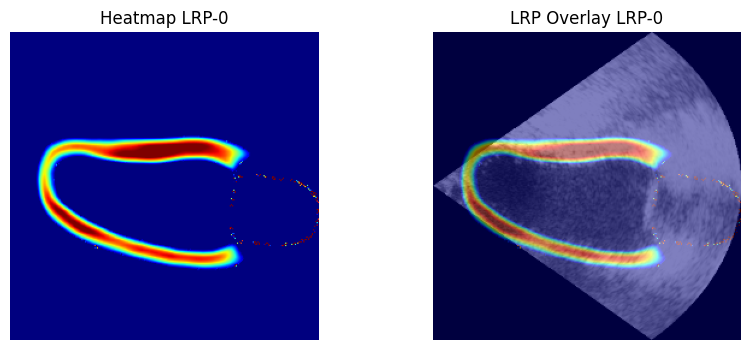


=== LRP Rule: epsilon ===
  raw relevance: -253.2646026611328 206.4307098388672 -2.1522939205169678


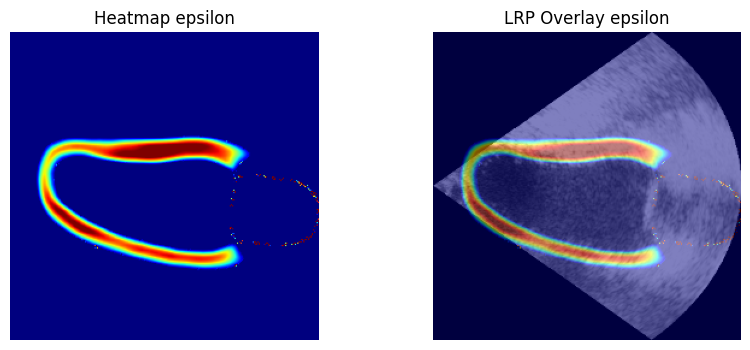


=== LRP Rule: z-plus ===
  raw relevance: 0.0 102.76355743408203 0.10797357559204102


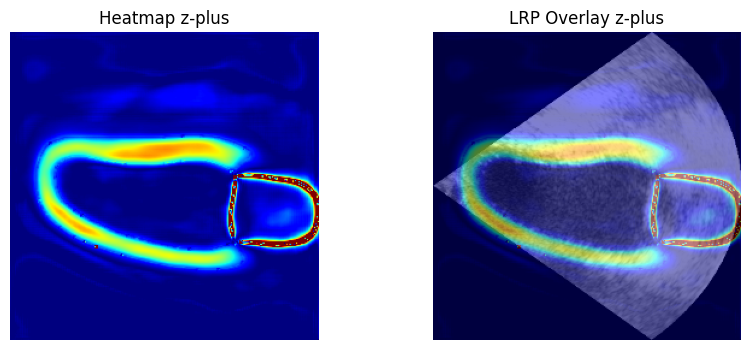


=== LRP Rule: gamma ===
  raw relevance: 0.0 214.89068603515625 0.14195574820041656


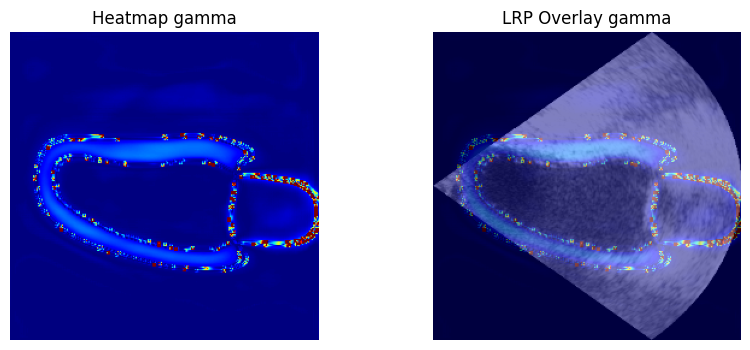


=== LRP Rule: alpha-beta ===
  raw relevance: 0.0 40675652.0 17766176.0


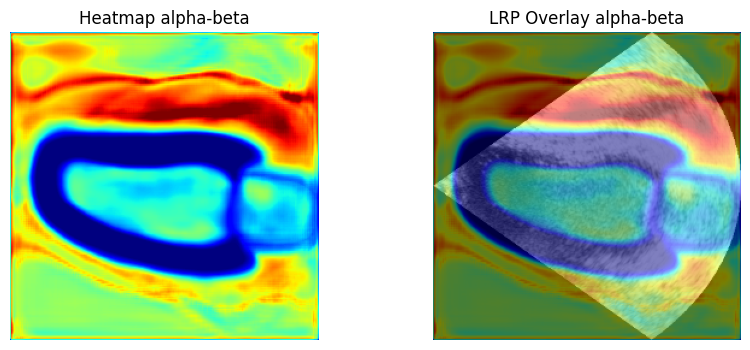


=== LRP Rule: flat ===
  raw relevance: -0.5408902168273926 -0.5408902168273926 -0.5408902168273926


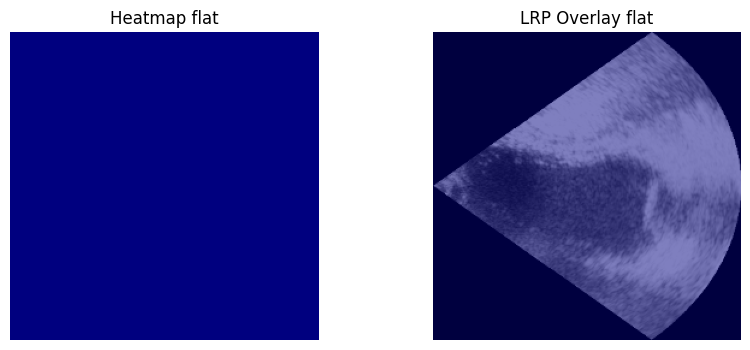


=== LRP Rule: w-squared ===
  raw relevance: -5.983713626861572 11.009410858154297 5.518373489379883



=== LRP Rule: zB ===
  raw relevance: -254.22235107421875 207.2394256591797 -2.1522905826568604


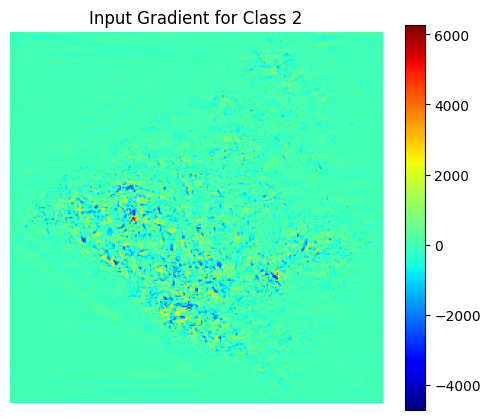

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import segmentation_models_pytorch as smp
import matplotlib.cm as cm

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If 3D, take middle slice (or squeeze if singleton)
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_idx = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_idx]
    
    # Normalize to [0, 1]
    mn, mx = img_data.min(), img_data.max()
    img = (img_data - mn) / (mx - mn) if mx > mn else img_data - mn
    
    # Resize (cv2 expects (width, height))
    img = cv2.resize(img.astype(np.float32), target_size)
    
    # Add channel and batch dims: [1,1,H,W]
    img = img[None, None, ...]
    return torch.tensor(img, dtype=torch.float32)

# ----------------------------
# Helper Functions for Heatmap Upsampling & Overlay
# ----------------------------
def resize_heatmap(hm: np.ndarray, target_size: tuple) -> np.ndarray:
    """
    Resize a single-channel heatmap to target_size using bilinear interpolation.
    """
    return cv2.resize(hm.astype(np.float32), (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)

def overlay_heatmap_on_image(image_np: np.ndarray, heatmap_np: np.ndarray, alpha=0.5, cmap='jet') -> np.ndarray:
    """
    Blend a heatmap onto an RGB image.
    
    image_np: HxWx3 RGB in [0,1]
    heatmap_np: HxW single-channel in [0,1]
    returns HxWx3 blended.
    """
    cm_map = cm.get_cmap(cmap)
    colored = cm_map(heatmap_np)[:, :, :3]  # HxWx3
    blended = (1 - alpha) * image_np + alpha * colored
    return np.clip(blended, 0, 1)

# ----------------------------
# Main Function
# ----------------------------
def main():
    model_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
    image_path = "/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0001_2CH_ED.nii.gz"

    # 1. Build U-Net with DenseNet121 encoder, 4 output classes
    model = smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4,         # background + 3 foreground
        activation=None
    )

    # 2. Load checkpoint (raw or wrapped), strict=False to allow mismatches
    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    res = model.load_state_dict(sd, strict=False)
    print("Missing keys:", res.missing_keys)
    print("Unexpected keys:", res.unexpected_keys)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 3. Load and prepare image
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad_()

    # ---- Forward Pass Split ----
    feats = model.encoder(image)
    dec_out = model.decoder(*feats)
    output = model.segmentation_head(dec_out)  # [1,4,H,W]
    seg_out = torch.sigmoid(output)
    print("Seg stats:", seg_out.min().item(), seg_out.max().item(), seg_out.mean().item())

    # Prepare original image for overlay
    orig = image[0,0].cpu().detach().numpy()
    orig_rgb = np.stack([orig]*3, axis=-1)

    # 4. Create segmentation mask with lower threshold
    mask = (seg_out.mean(1, keepdim=True) > 0.1).float()

    # 5. LRP on final conv
    final_conv = model.segmentation_head[0]
    class_idx = 2  # choose channel: 0=background, 1-3=foreground

    for rule, fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule} ===")
        R = output.detach().clone()
        R = lrp_class_specific(R, class_idx)

        if rule == "flat":
            R = fn(final_conv, dec_out, R, seg_mask=mask)
        else:
            R = fn(final_conv, dec_out, R)

        if R.shape[1] > 1:
            R = R.mean(1, keepdim=True)

        # Optional: print raw relevance stats
        raw = R.detach()
        print("  raw relevance:", raw.min().item(), raw.max().item(), raw.mean().item())

        # Mask relevance
        R = apply_segmentation_mask(raw, mask, threshold=0.1)

        # Prepare heatmap
        hm = R.squeeze().detach().cpu().numpy()
        p99 = np.percentile(hm, 99)
        hm_clipped = np.clip(hm, 0, p99)
        hm_norm = (hm_clipped - hm_clipped.min()) / (hm_clipped.max() - hm_clipped.min() + 1e-8)

        # Upsample to input size
        hm_resized = resize_heatmap(hm_norm, target_size=orig_rgb.shape[:2])

        # Overlay
        overlay = overlay_heatmap_on_image(orig_rgb, hm_resized, alpha=0.5, cmap='jet')

        # Display
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(hm_resized, cmap='jet')
        plt.title(f"Heatmap {rule}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title(f"LRP Overlay {rule}")
        plt.axis('off')
        plt.show()

    # 6. Input gradient visualization
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad[0,0].detach().cpu().numpy()

    plt.figure(figsize=(6,5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar()
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

Segmentation output stats: min = 1.7001841712271926e-08 max = 0.9999960660934448 mean = 0.10054478049278259


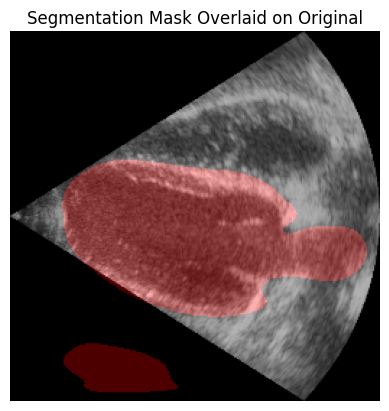


=== LRP Rule: LRP-0 ===
Relevance stats: min = -224.2615966796875 max = 345.03265380859375 mean = -0.3308945596218109


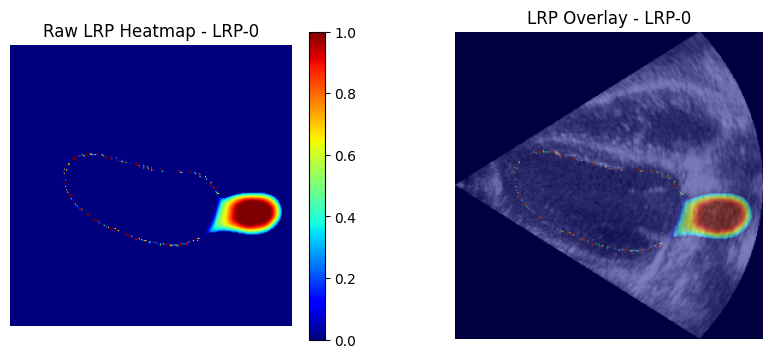


=== LRP Rule: epsilon ===
Relevance stats: min = -223.77069091796875 max = 344.2433166503906 mean = -0.33089643716812134


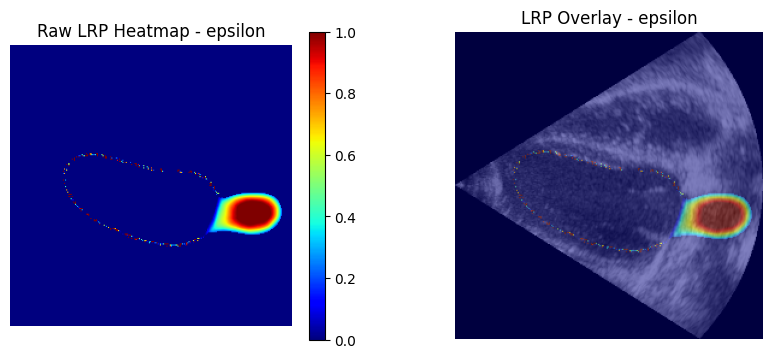


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 66.26087188720703 mean = 0.09174613654613495


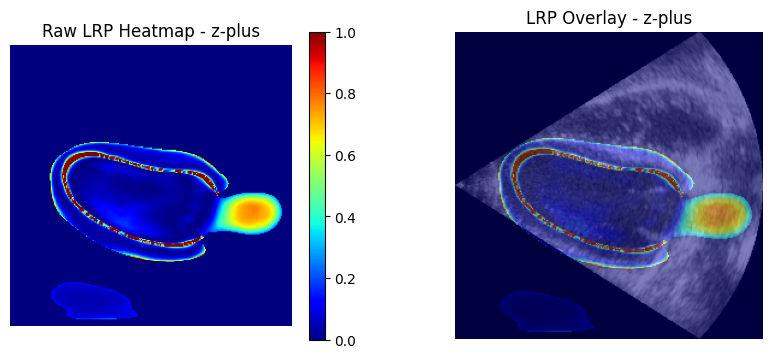


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 133.86080932617188 mean = 0.07264909148216248


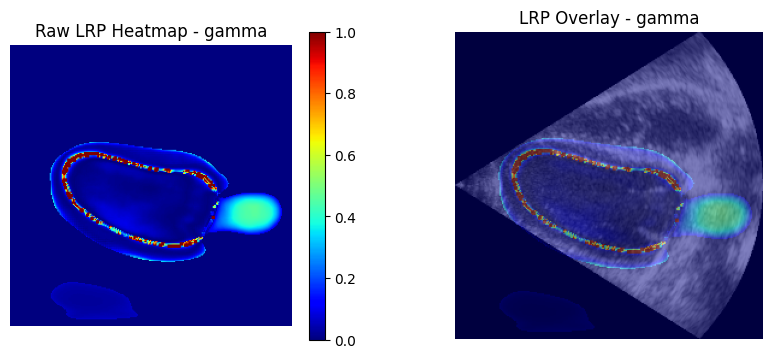


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 685.50732421875 mean = 0.44633063673973083


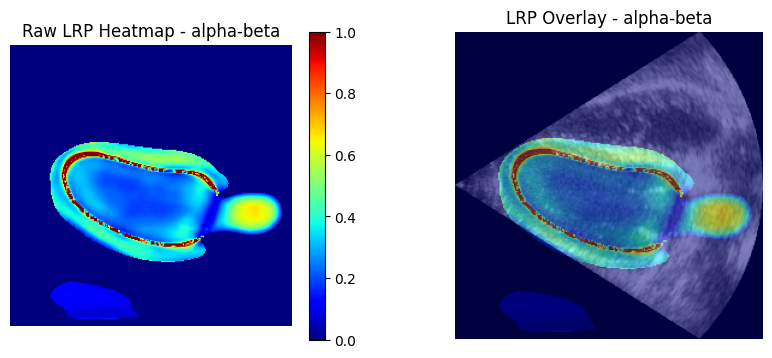


=== LRP Rule: flat ===
Relevance stats: min = -0.4943287968635559 max = 0.0 mean = -0.13009923696517944



=== LRP Rule: w-squared ===
Relevance stats: min = -3.5731711387634277 max = 5.5231781005859375 mean = 0.5007717609405518



=== LRP Rule: zB ===
Relevance stats: min = -224.2615966796875 max = 345.03265380859375 mean = -0.3308945596218109


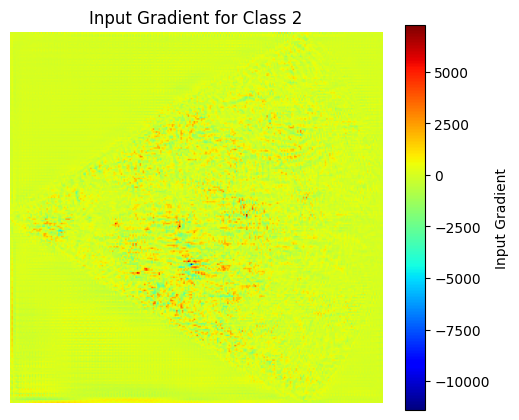

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2  # For image resizing
import segmentation_models_pytorch as smp

# ----------------------------
# Helper Function to Load .nii.gz Image
# ----------------------------
def load_nii_image(image_path, target_size=(256, 256)):
    """
    Loads a 2D .nii.gz image, normalizes it, resizes it,
    and converts it to a torch tensor of shape [1, 1, H, W].
    
    Parameters:
        image_path (str): Path to the .nii.gz image.
        target_size (tuple): Desired output size as (width, height).
    
    Returns:
        torch.Tensor: The processed image tensor.
    """
    nii = nib.load(image_path)
    img_data = nii.get_fdata()
    
    # If the image is 3D, handle singleton dimensions or choose the middle slice.
    if img_data.ndim == 3:
        if img_data.shape[2] == 1:
            img_data = np.squeeze(img_data, axis=2)
        else:
            slice_index = img_data.shape[2] // 2
            img_data = img_data[:, :, slice_index]
    
    # Normalize to [0, 1]
    img_min, img_max = img_data.min(), img_data.max()
    if img_max - img_min > 0:
        img_data = (img_data - img_min) / (img_max - img_min)
    else:
        img_data = img_data - img_min
        
    # Resize using cv2 (target_size provided as (width, height))
    new_W, new_H = target_size
    resized = cv2.resize(img_data.astype(np.float32), (new_W, new_H))
    
    # Add channel dimension for a single-channel image: [1, H, W]
    resized = np.expand_dims(resized, axis=0)
    # Add batch dimension: [1, 1, H, W]
    resized = np.expand_dims(resized, axis=0)
    
    return torch.tensor(resized, dtype=torch.float32)

# ----------------------------
# Main Function
# ----------------------------
def main():
    # 1. Setup & Model Loading
    model_path = r"/home/sailesh/Desktop/Rohit/models/eff100icientn_best_nii.pth"
    image_path = r"/home/sailesh/Desktop/Rohit/dataset/nii_img/patient0003_4CH_ED.nii.gz"
    
    # Define UNet Model with EfficientNet-B3 Encoder
    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=1,
        classes=3,  # Three foreground classes
        activation=None  # No activation; BCEWithLogitsLoss applies sigmoid
    )
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load image (shape: [1, 1, H, W])
    image = load_nii_image(image_path, target_size=(256, 256)).to(device)
    image.requires_grad = True
    
    # ---- Modified Forward Pass ----
    # Instead of calling model(image) directly, we manually call the encoder,
    # decoder, and then the segmentation head.
    encoder_features = model.encoder(image)
    decoder_output = model.decoder(*encoder_features)
    output = model.segmentation_head(decoder_output)  # Final output: [1, 3, H, W]
    # ---------------------------------
    
    segmentation_output = torch.sigmoid(output)
    
    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())
    
    # Convert the original image for visualization.
    # Replicate the single channel to form an RGB image.
    orig_img_np = image[0, 0].detach().cpu().numpy()  # [H, W]
    orig_img_np = np.stack([orig_img_np]*3, axis=-1)     # [H, W, 3]
    orig_img_np = np.clip(orig_img_np, 0, 1)
    
    # 2. Visualize Segmentation Mask Overlay
    # (Assumes overlay_seg_mask_on_image is defined elsewhere)
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()
    
    # 3. Run Each LRP Rule and Visualize Results (applied only to the final output layer)
    class_idx = 2  # Choose the output channel (class) to analyze

    # Extract the final convolution layer from the segmentation head.
    # (Assuming model.segmentation_head is a Sequential and its first element is a Conv2d)
    final_conv = model.segmentation_head[0]

    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        # Create a clone of the final output and extract relevance for the specified class
        relevance = output.detach().clone()  # [B, 3, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B, 1, H, W]
        
        # Apply LRP to the final output layer.
        # Pass the activation that goes into the final convolution (decoder_output) as input.
        if rule_name == "flat":
            relevance = lrp_fn(final_conv, decoder_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(final_conv, decoder_output, relevance)
        
        # If multiple channels exist, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)
        
        # Optionally apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())
        
        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)
        
        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()
    
    # 4. (Optional) Visualize Input Gradient
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0].cpu().numpy()
    
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()
    
if __name__ == "__main__":
    main()